**Student Name**: Rajkishore Nandi

**Student Roll No**: 21f1006016

**DEADLINE: 29th Nov, 2023**

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [84]:
# import necessary libraries here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

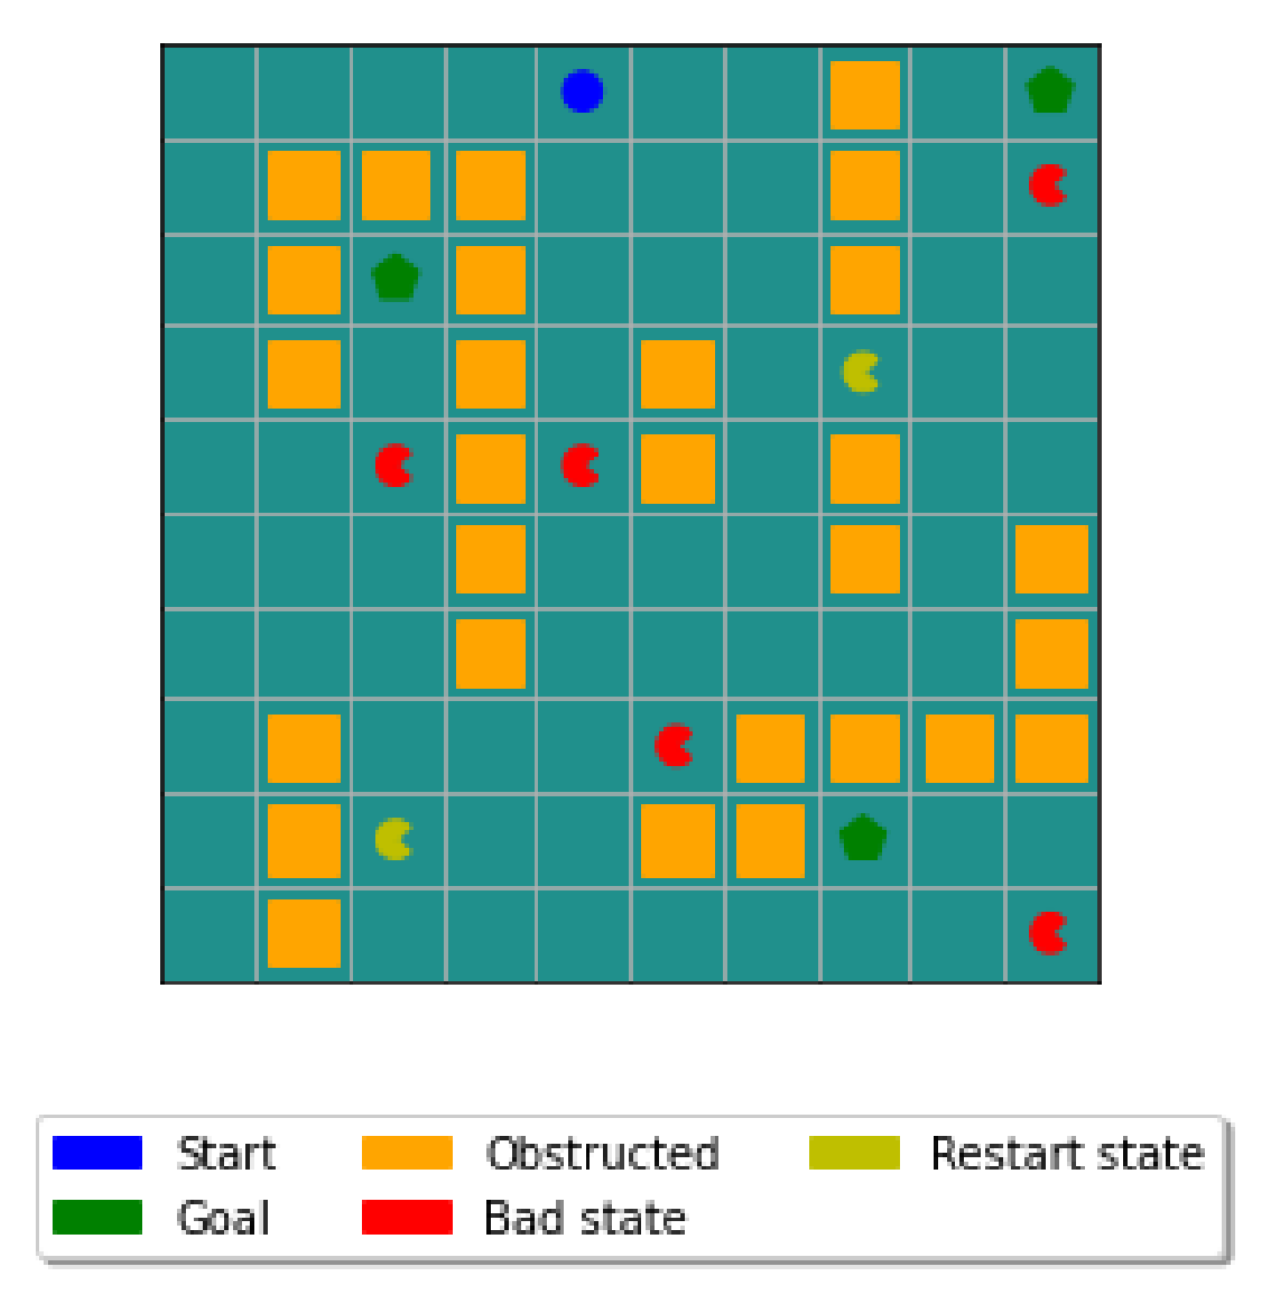

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

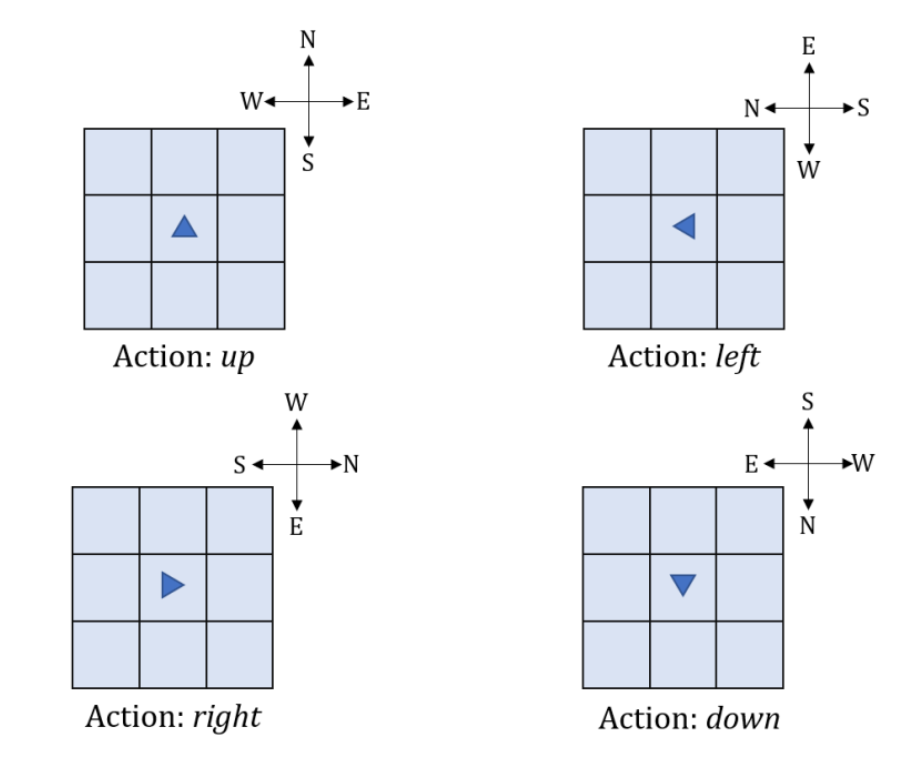

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [85]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Converts row_column format to state number
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]


# Converts state number to row_column format
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [86]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [87]:
def custom_env_instantiation(start_state, p_good_transition,wind):
  num_cols = 10
  num_rows = 10

  # coordinates of the cells representing obstruction
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

  # lsit of bad states
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

  # list of restart states
  restart_states = np.array([[3,7],[8,2]])
  # list of goal states i.e. terminal states
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create the environment's model
  gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states,
                wind = wind)

  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)

  gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=p_good_transition,
                                bias=0.5)
  env = gw.create_gridworld()
  return env

In [88]:
def reward_curve(rewards):
  mean_rewards = np.mean(rewards,axis = 0)
  plt.figure(figsize=(10,6))
  plt.plot(mean_rewards)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Reward Curve')
  plt.show()

In [89]:
def steps_to_goal(steps):
  mean_goalState_steps = np.mean(steps,axis = 0)
  plt.figure(figsize=(10,6))
  plt.plot(mean_goalState_steps)
  plt.xlabel('Episode')
  plt.ylabel('Steps')
  plt.title('Number of Steps per eposide to reach goal ')
  plt.show()

In [90]:
def heatMap_states_visit(state_visit_counts):
  plt.figure(figsize=(8,7))
  mean_state_visit_count=np.mean(state_visit_counts,axis=0)
  sns.heatmap(mean_state_visit_count.reshape(10,10), cmap='viridis', annot=True, fmt='.0f', cbar=True)
  plt.show()

In [91]:
def heatMap_optimal_policy(env, action_value_function):
    m = 10
    n = 10
    plt.figure(figsize=(8, 8))

    ext = 0.1
    arrow_map = {0: (0, ext), 1: (0, -ext), 3: (ext, 0), 2: (-ext, 0)}

    action_values_matrix = np.zeros((env.num_rows, env.num_cols))

    for state in range(env.num_states):
        obs_state_seq = row_col_to_seq(env.obs_states, 10)

        A = list(range(env.num_actions))
        max_q_value = max([action_value_function[state][action] for action in A])
        row_idx, col_idx = seq_to_col_row(state, env.num_cols)[0]
        action_values_matrix[row_idx, col_idx] = max_q_value

    plt.imshow(action_values_matrix, origin='upper', extent=[0, n, 0, m])

    for state in range(env.num_states):
        if (state in env.goal_states_seq) or (state in row_col_to_seq(env.obs_states, env.num_cols)):
            continue

        A = list(range(env.num_actions))
        max_q_value = max([action_value_function[state][action] for action in A])
        row_idx, col_idx = seq_to_col_row(state, env.num_cols)[0]
        action_values_matrix[row_idx, col_idx] = max_q_value
        opt_actions = [action for action in A if action_value_function[state][action] == max_q_value]

        for opt_action in opt_actions:
            x, y = col_idx + 0.5, m - 1 - row_idx + 0.5
            plt.arrow(x, y, arrow_map[opt_action][0], arrow_map[opt_action][1],
                      head_width=0.1, head_length=0.1,color='red')
            plt.text(x - 0.4, y - 0.4, f'${max_q_value:.2f}$',color='red',fontsize=6)

    plt.grid(True)

    plt.xticks(np.arange(0, n, 1), np.arange(0, n))
    plt.yticks(np.arange(0, m, 1), np.arange(m-1, -1,-1))

    plt.colorbar(shrink=0.8)
    plt.show()


## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

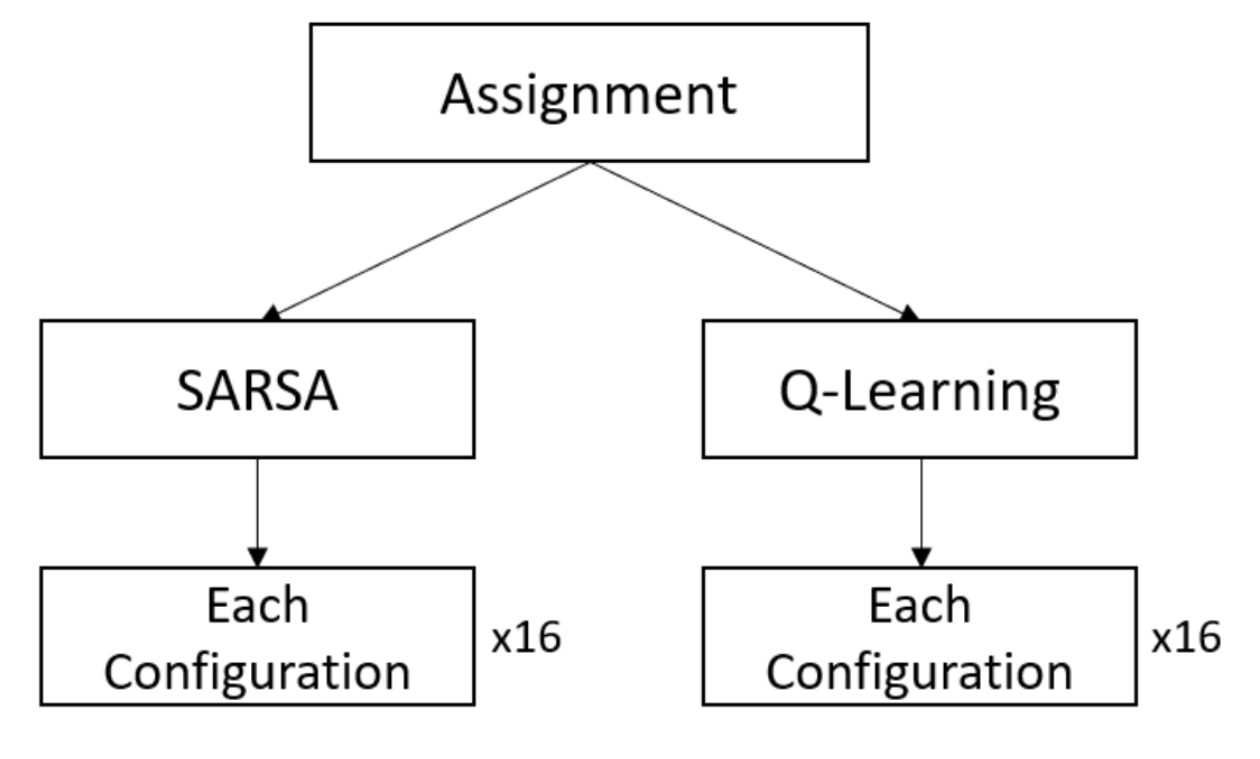

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

### (1) Q-Learning

In [92]:
class QLearning():

  def __init__(self,env,alpha,gamma,epsilon=0,temp=1,greedy=False):
    self.greedy = greedy
    self.env = env
    self.aplha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.action_value_function={}
    self.temp = temp
    self.state_visit_count = np.zeros(env.num_states)

    for state in range(self.env.num_states):
      self.action_value_function[state] = {}
      for action in range(self.env.num_actions):
        self.action_value_function[state][action] = np.random.rand()
    for state in self.env.goal_states_seq:
      for action in range(self.env.num_actions):
        self.action_value_function[state][action] = 0

  def action(self,state):
    if(self.greedy):
      if np.random.rand() >= self.epsilon:
        action = max(self.action_value_function[state],key=self.action_value_function[state].get)
      else:
        action = np.random.choice(list(self.action_value_function[state].keys()))
      return action
    else:
      value_function = np.exp(np.array(list(self.action_value_function[state].values())))/self.temp
      softmax_probability = value_function/np.sum(value_function)
      return np.random.choice(len(softmax_probability), p=softmax_probability)

  def train(self,total_episode):
    episode_count = 0
    self.reward_per_episode = np.zeros(total_episode)
    self.reach_goal = np.ones(total_episode) * 100
    while episode_count < total_episode:
      state = self.env.reset()
      self.state_visit_count[state]+=1
      episodic_timestep = 0
      total_reward = 0
      while True:
        if episodic_timestep > 100:
          break
        action =  self.action(state)
        next_state, reward = self.env.step(state,action)
        total_reward += reward
        self.state_visit_count[next_state] += 1
        if next_state in self.env.goal_states_seq:
          self.reach_goal[episode_count] = episodic_timestep
          break
        self.action_value_function[state][action] = self.action_value_function[state][action] + self.aplha * (reward[0] + self.gamma * np.max(list(self.action_value_function[next_state].values())) - self.action_value_function[state][action])
        state = next_state
        episodic_timestep+=1
      self.reward_per_episode[episode_count] = total_reward
      episode_count +=1

#### Configuration Parameters - 1
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = Greedy

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),0.7,wind = False)
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ->
# Iteration Count: 1

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [93]:
env = custom_env_instantiation(np.array([[0,4]]),0.7,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

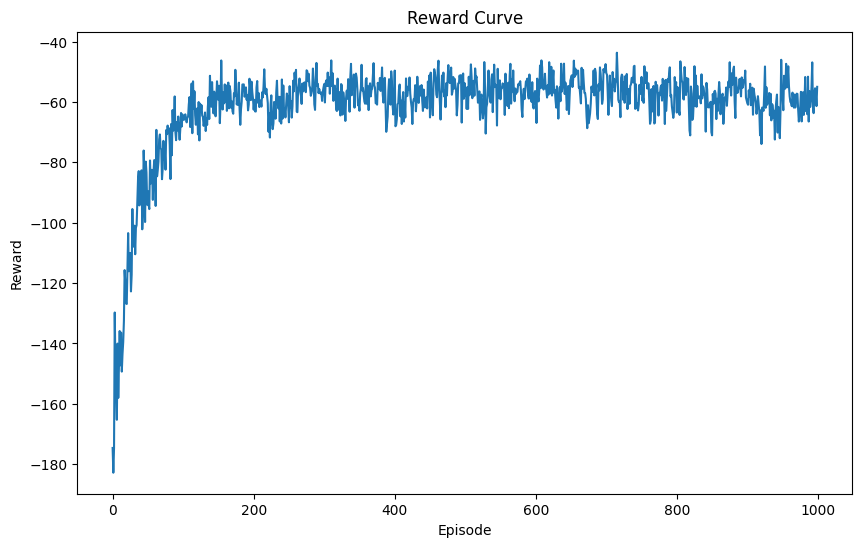

In [94]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

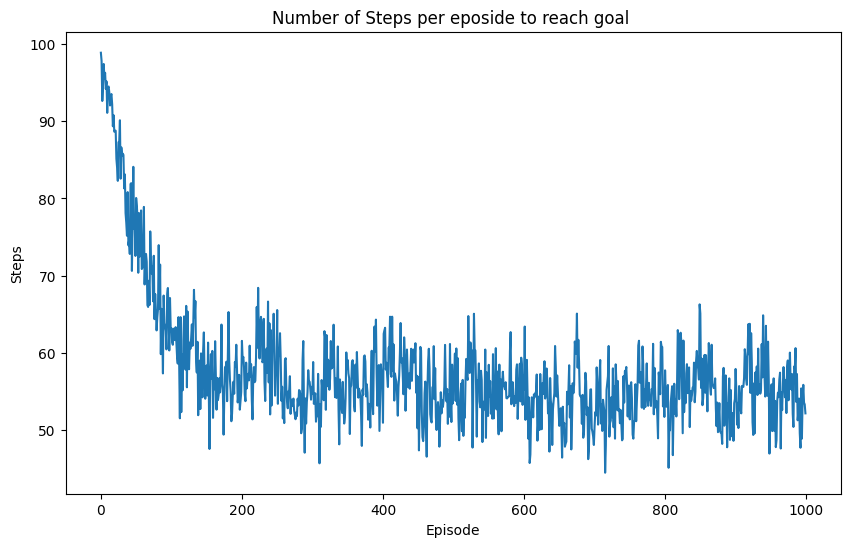

In [95]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

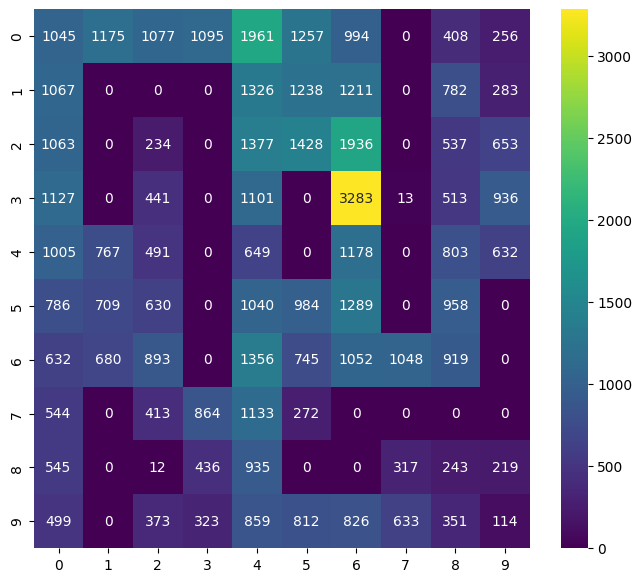

In [96]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

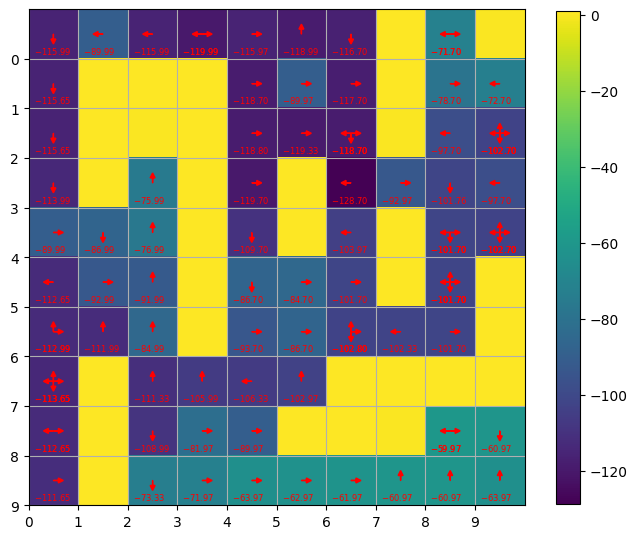

In [97]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and epsilon = 0.001.The agent tries to explore less and take greedy actions more.
*   The agnet tries to find the optimal path but because of stochasticity of p = 0.7 Q functions hasn't converged after 1000 episodes and has only reached till -50 reward value and approx 50 steps to reach Goal state.

*   The state visit graph shows that the agent is prefering the left path to the Goal state (2,2)





**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (0,4) which is closer to the left Goal state (2,2) so the agent has started preferring left path.
*   The p = 0.7 has kept that uncertainty in the transitions and thats why it takes more episodes for the agent to converge.



#### Configuration Parameters - 2
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Greedy

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ->
# Iteration Count: 1

In [37]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  0.9
epsilon =  0.001


Train the agent

In [100]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 0.9,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

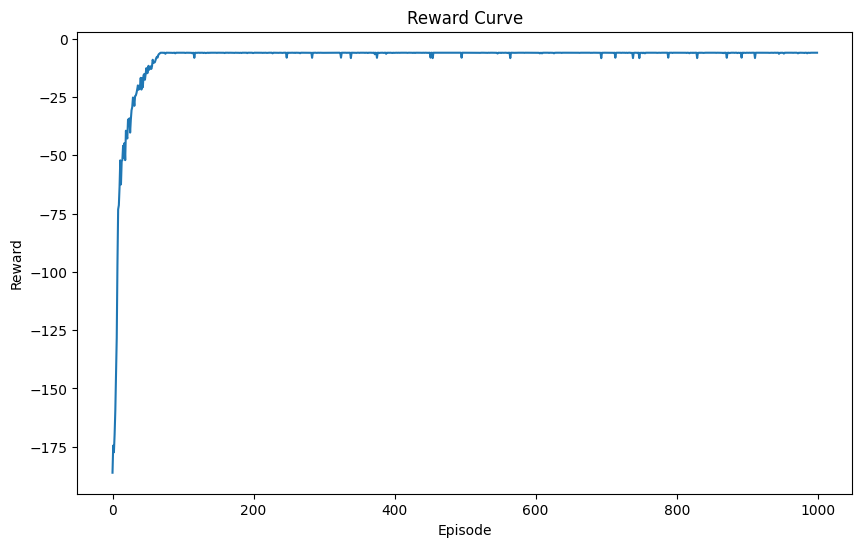

In [101]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

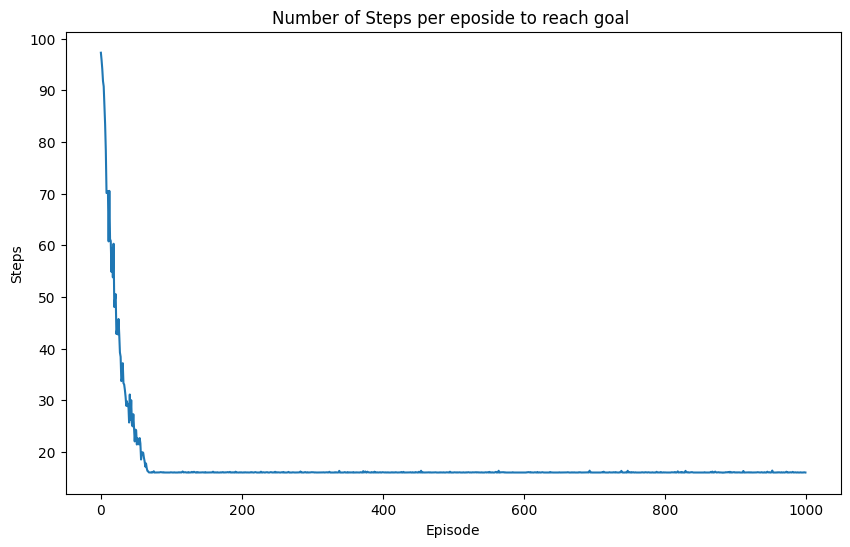

In [102]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.


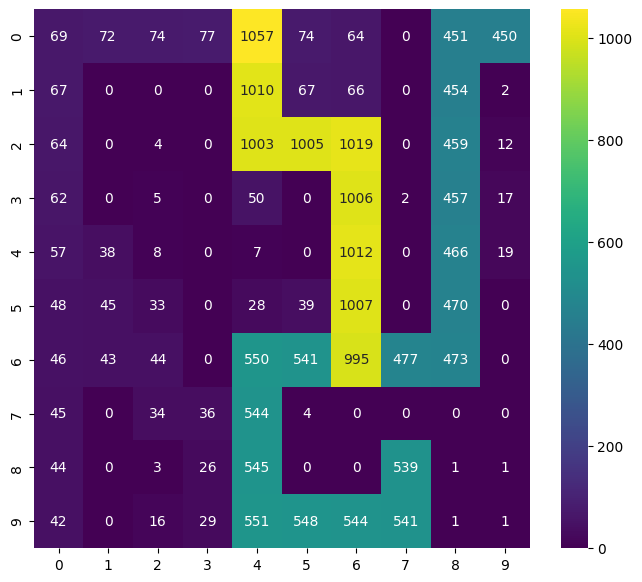

In [103]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

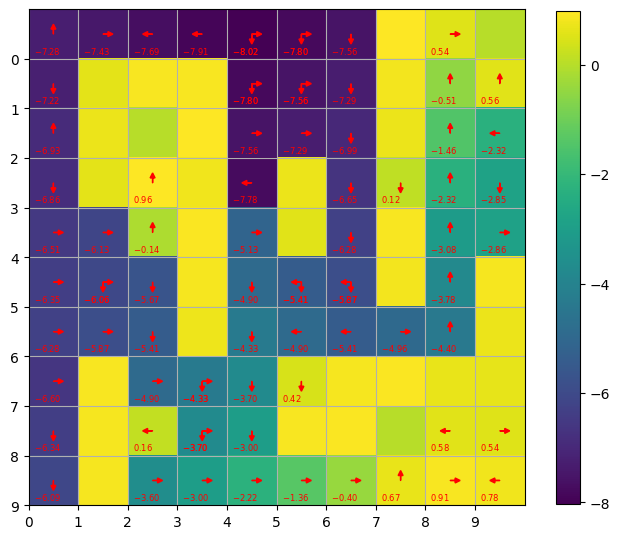

In [45]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 0.9 and epsilon = 0.001.The agent tries to explore less and take greedy actions more.
*   The agnet tries to find the optimal path and as there is no  stochasticity as p = 1. Q functions has converged after 1000 episodes and has reached till -7 approx reward value and approx 15 steps to reach Goal state.

*   The state visit graph shows that the agent is prefering the middle to the Goal state (8,7)





**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (0,4) and as the left path has a bad state so the agent follows middle path to goal state (8,7).The transition also becomes deterministic.
*   The p = 1 has kept no uncertainty in the transitions and thats why the agent converges.


*   The agent either follows the mid path or the path to the right that is to Goal state (0,9).






#### Configuration Parameters - 3
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = Greedy

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),0.7,wind = False)

reward_results = {}
iter=0

for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ->
# Iteration Count: 1

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [46]:
env = custom_env_instantiation(np.array([[3,6]]),0.7,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

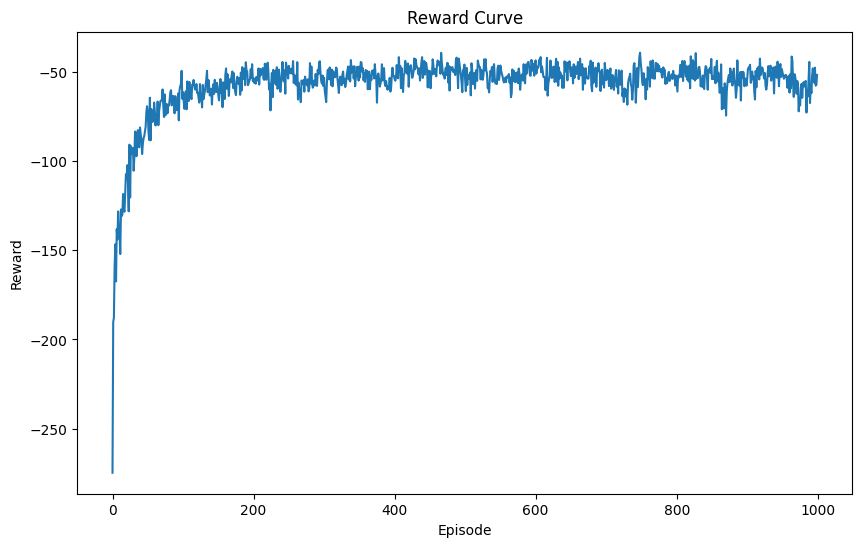

In [47]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

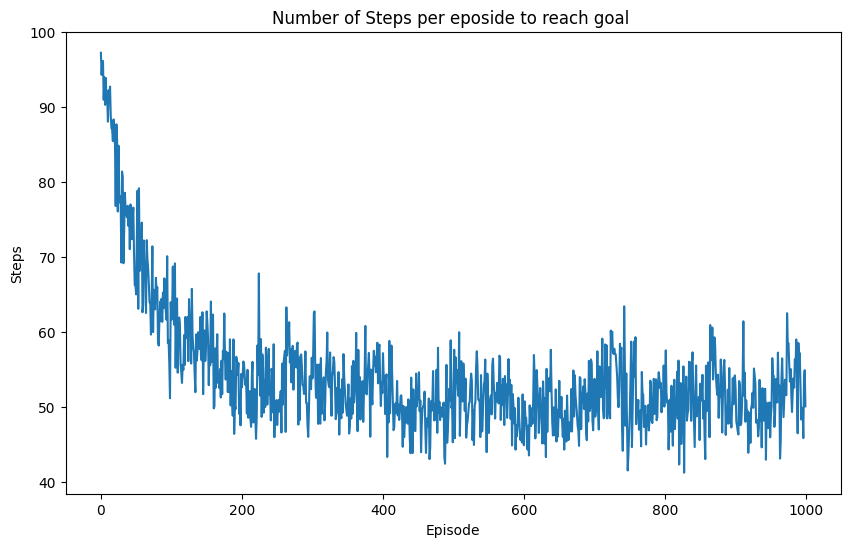

In [48]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

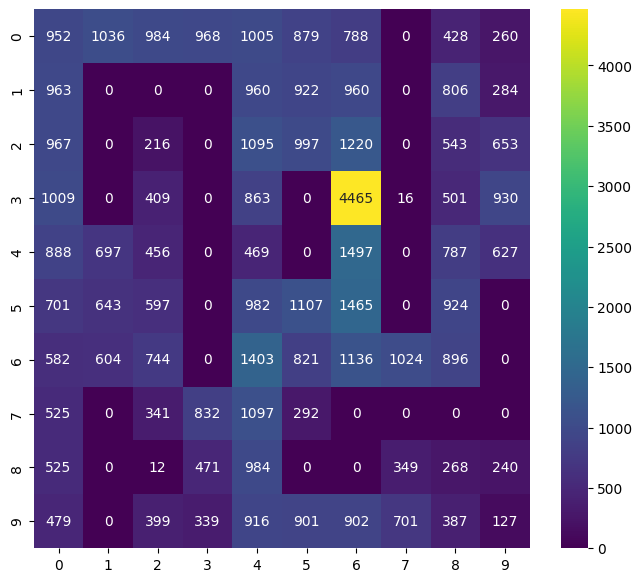

In [49]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

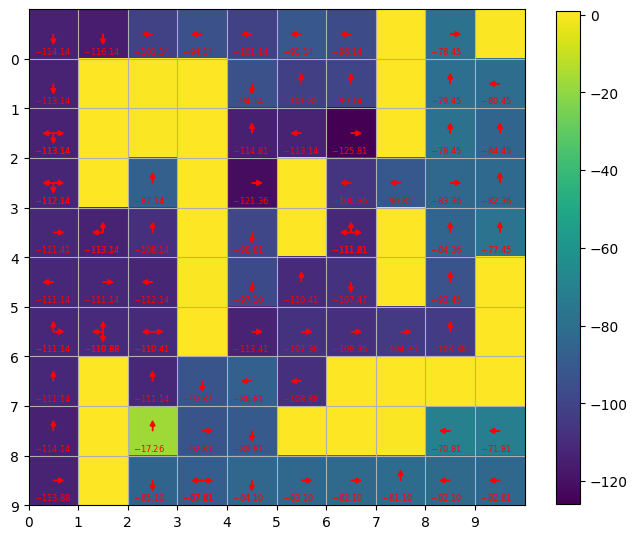

In [50]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and epsilon = 0.001.The agent tries to explore less and take greedy actions more.
*   The agnet tries to find the optimal path but there is stochasticity as p = 0.7. Q functions has not converged after 1000 episodes and has reached till -50 approx reward value and approx 50 steps to reach Goal state.

*   The state visit graph shows that the agent is exploring all states still and hasn't shown any preference in any direction.





**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (3,6) and no optimal path yet found by agent.
*   The p = 0.7 has kept uncertainty in the transitions and thats why the agent doesn't converge.


*   The agent while transition is stochastic so is visiting all states yet.






#### Configuration Parameters - 4
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Greedy

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)

reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ->
# Iteration Count: 1

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  0.9
epsilon =  0.001


Train the agent

In [51]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 0.9,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

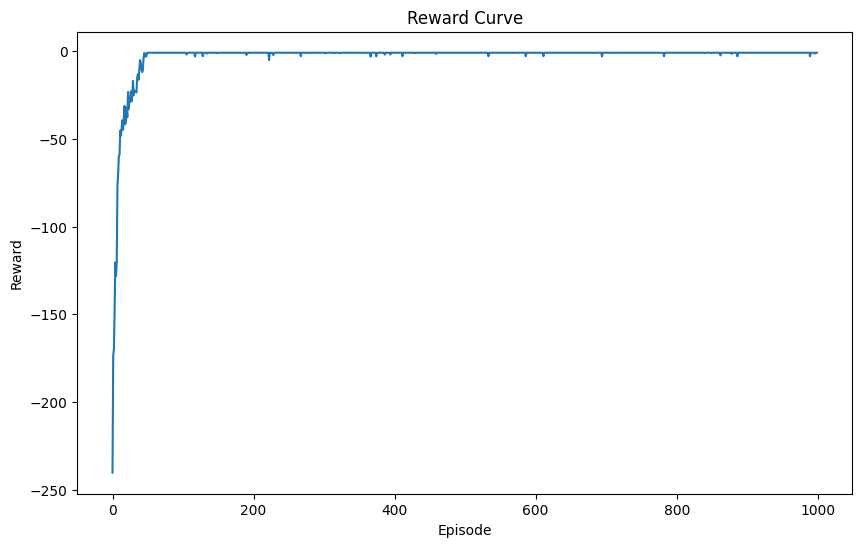

In [52]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

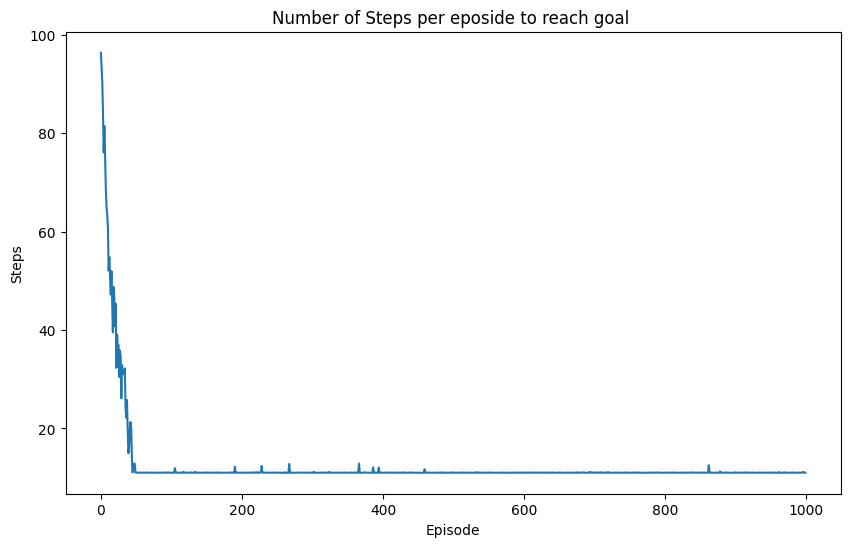

In [53]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

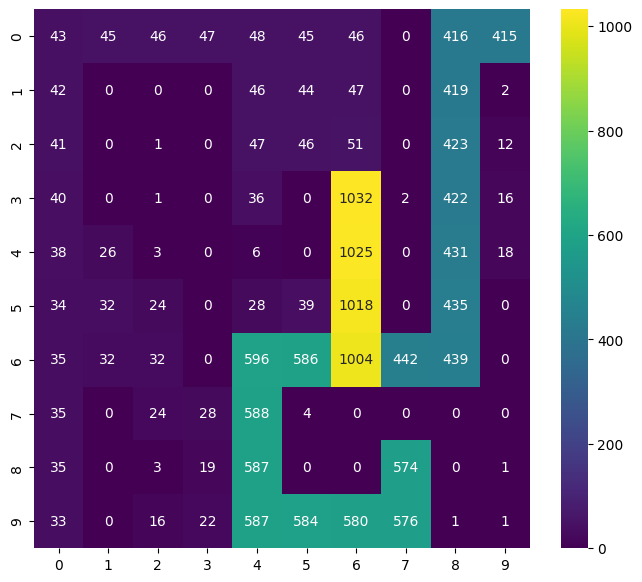

In [54]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

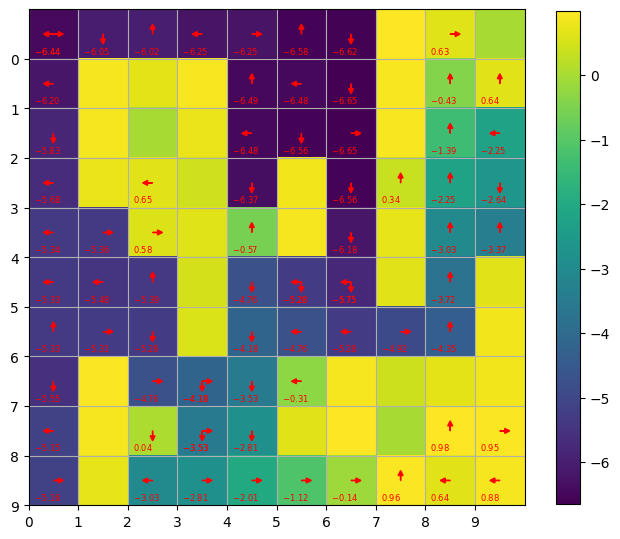

In [55]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 0.9 and epsilon = 0.001.The agent tries to explore less and take greedy actions more.
*   The agnet tries to find the optimal path and  there is no stochasticity as p = 1. Q functions has converged after 1000 episodes and has reached till -3 approx reward value and approx 12 steps to reach Goal state.

*   The state visit graph shows that the agent has explored states close to goal state more and has converged.




**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (3,6) and the optimal path is being found by the agent.The goal state (8,7) or (0,9) can be reached by the agent.
*   The p = 1 has kept no uncertainty in the transitions and thats why the agent converges by 1000 episodes.








#### Configuration Parameters - 5
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = Softmax

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),0.7,wind = False)

reward_results = {}
iter=0

for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ->
# Iteration Count: 14 ::: Hyperparameter T

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("temp = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
temp =  0.1


In [69]:
env = custom_env_instantiation(np.array([[0,4]]),0.7,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,temp = 0.1,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

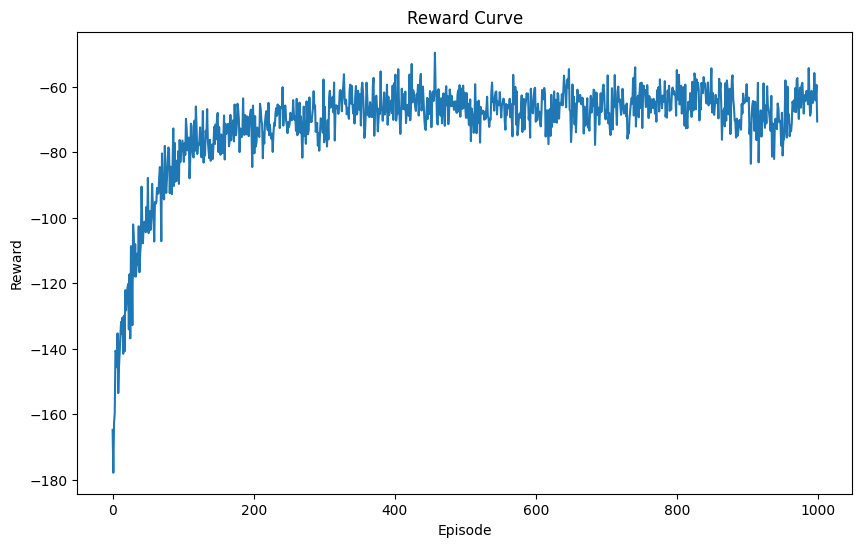

In [70]:
reward_curve(rewards)


2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

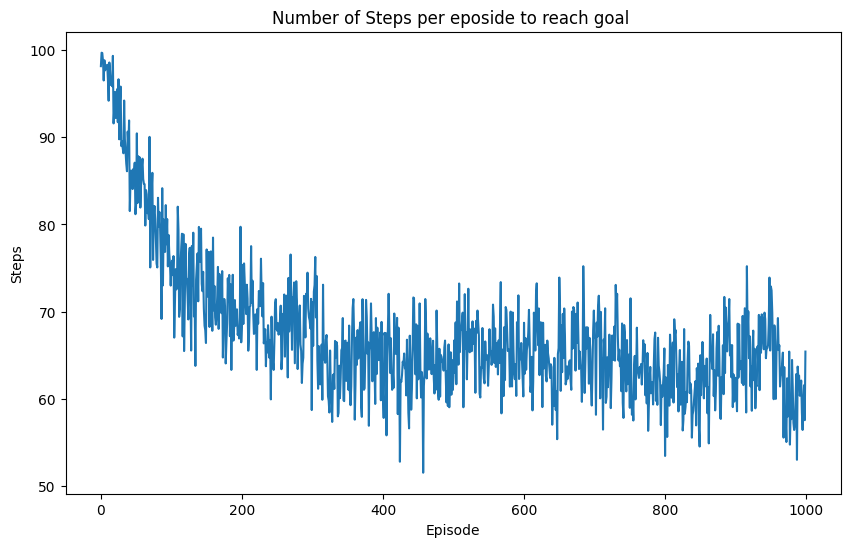

In [71]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

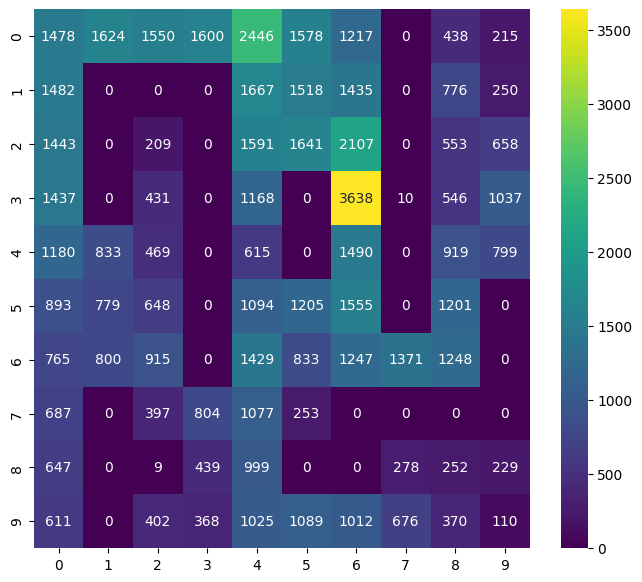

In [72]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

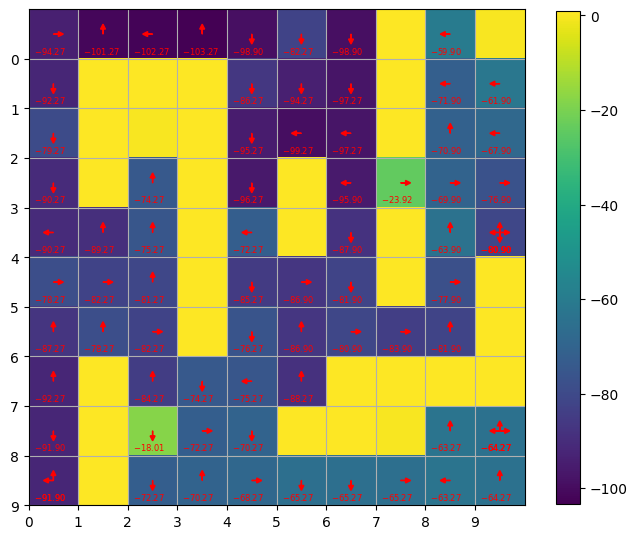

In [73]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and temp = 0.1.The agent tries to explore in softmax fashion.
*   The agnet tries to find the optimal path and  there is stochasticity as p = 0.7. Q functions has not converged after 1000 episodes and has reached till -50 approx reward value and approx 55 steps to reach Goal state.

*   The state visit graph shows that the agent has explored all states and is still trying to figure out the optimal path.




**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (0,4) and the optimal path is not being found out yet by the agent as the env transitions are stochastic.
*   The p = 0.7 has kept uncertainty in the transitions and thats why the agent doesn't converge by 1000 episodes.








#### Configuration Parameters - 6
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)

reward_results = {}
iter=0

for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ->
# Iteration Count: 14 ::: Hyperparameter T

In [ ]:
best_hp,max_mean_reward = None,-np.inf
for hp,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_hp = hp
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("learning_rate = ",best_hp[0])
print("discounting_factor = ",best_hp[1])
print("temp = ",best_hp[2])

Best Hyperparameters:
learning_rate =  1.0
discounting_factor =  1.0
temp =  0.1


Train the Agent

In [79]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,temp = 0.1,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

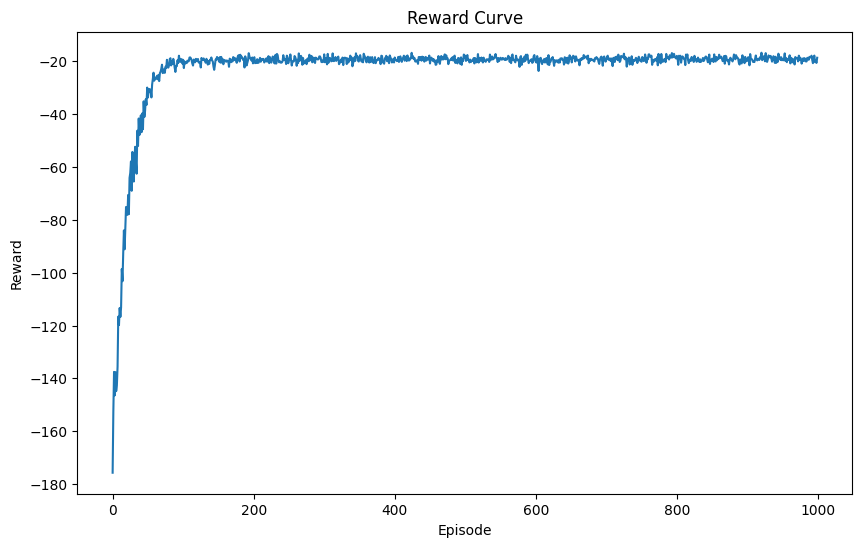

In [80]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

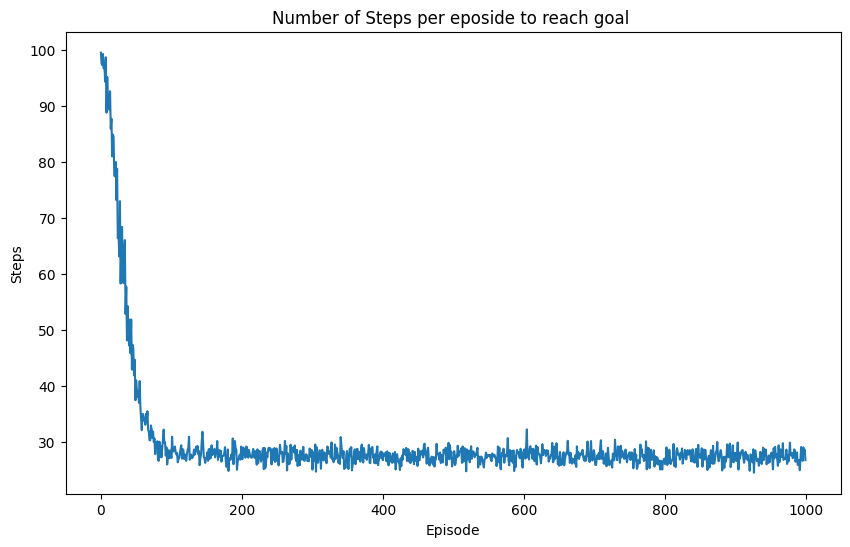

In [81]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

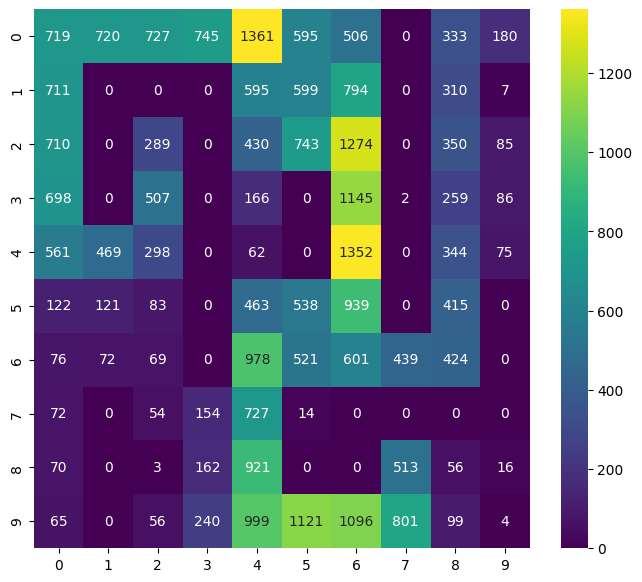

In [82]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

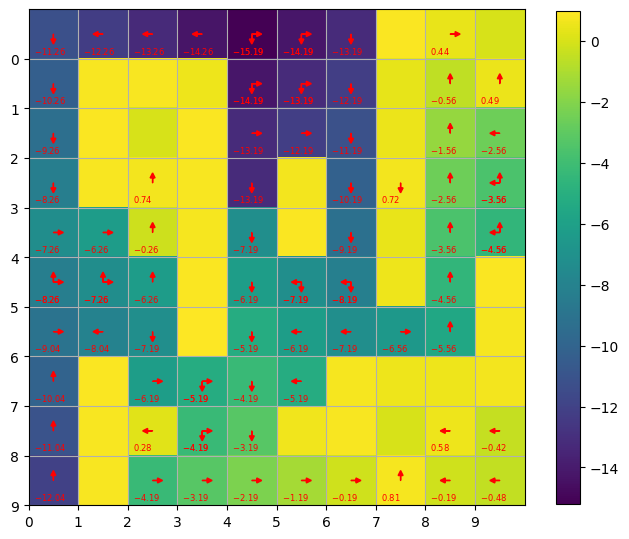

In [83]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and temp = 0.1.The agent tries to explore in softmax fashion.
*   The agnet tries to find the optimal path and  there is no stochasticity as p = 1. Q functions has not fully converged after 1000 episodes as agent follows softmax approach and there is quite of exploration in action selection.

*   The state visit graph shows that the agent has explored  states close to optimal path morer frequently but it can do better as it hasn't shown confidence yet in one path.



**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (0,4) and the optimal path is not completely  being found out yet by the agent as the agent follows softmax with temp value = 0.1 .
*   The p = 1 has kept no uncertainty in the transitions and thats why the agent converge to a much higher value compared to p = 0.7 by 1000 episodes.








#### Configuration Parameters - 7
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = Softmax

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),0.7,wind = False)

reward_results = {}
iter=0

for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ->
# Iteration Count: 14 ::: Hyperparameter T

In [ ]:
best_hp,max_mean_reward = None,-np.inf
for hp,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_hp = hp
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("learning_rate = ",best_hp[0])
print("discounting_factor = ",best_hp[1])
print("temp = ",best_hp[2])

Best Hyperparameters:
learning_rate =  1.0
discounting_factor =  1.0
temp =  2


Train the Agent

In [104]:
env = custom_env_instantiation(np.array([[3,6]]),0.7,wind = False)
agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,temp = 2,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

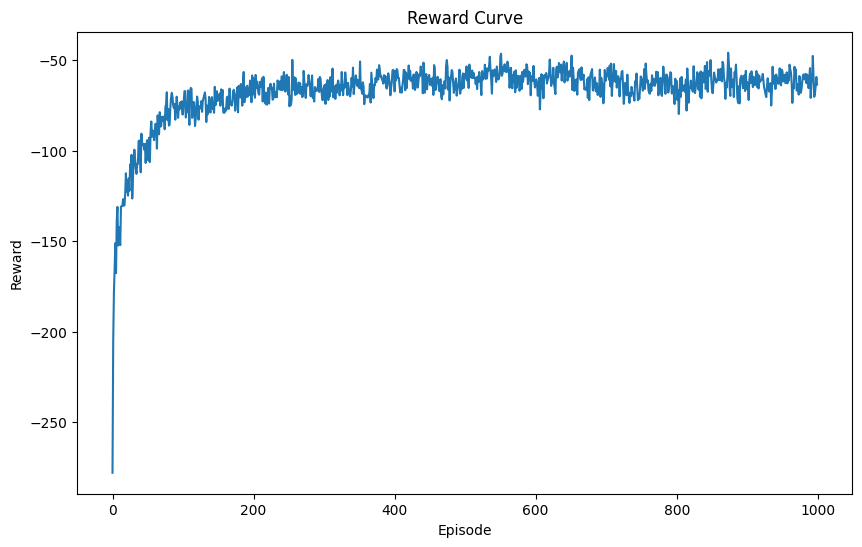

In [105]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

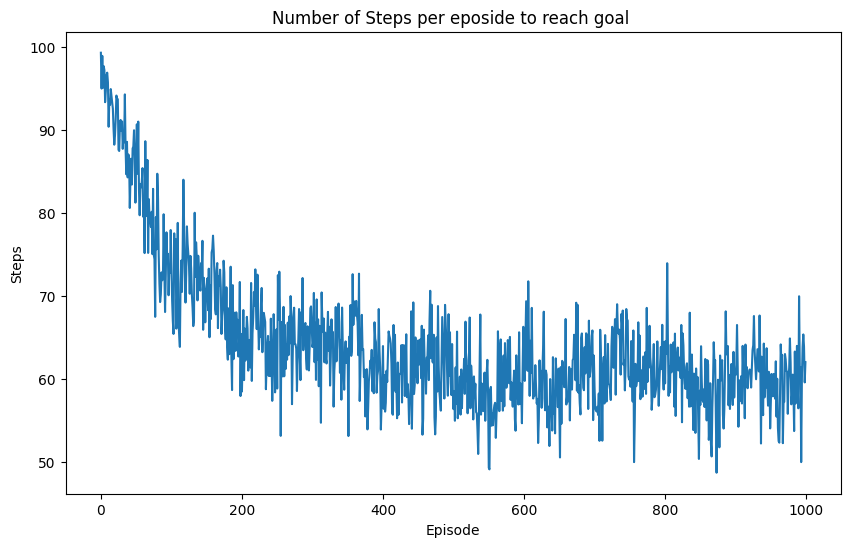

In [106]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

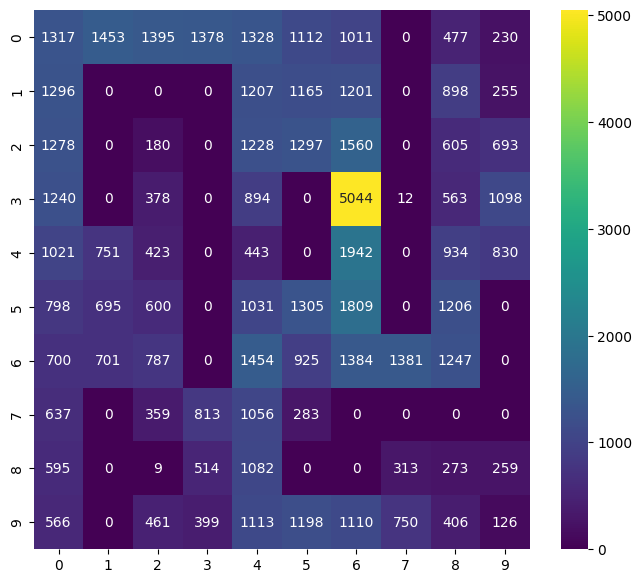

In [107]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

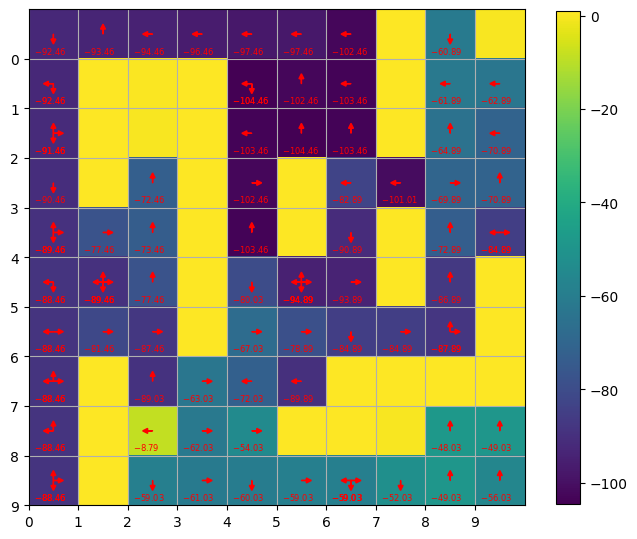

In [108]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and temp = 2 .The agent tries to explore in softmax fashion with high close to uniform policy.
*   The agnet tries to find the optimal path and  there is  stochasticity as p = 0.7. Q functions has not converged after 1000 episodes as agent follows softmax approach and there is quite of exploration in action selection.The reward has incraesed to only -50 approx with steps to reach goal state is also close to 50.

*   The state visit graph shows that the agent is exploring all states and still hasn't found any sense of direction to move towards the Goal state.



**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (3,6) and the optimal path is not at all being found out yet by the agent as the agent follows softmax with temp value = 2 .
*   The p = 0.7 has kept uncertainty in the transitions and thats why the agent doesn't converge yet.







#### Configuration Parameters - 8
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

Parameter Tuning

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)

reward_results = {}
iter=0

for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2]:
      iter+=1
      print("#",f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","->")
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = QLearning(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

# Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ->
# Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ->
# Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ->
# Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ->
# Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ->
# Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ->
# Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ->
# Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ->
# Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ->
# Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ->
# Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ->
# Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ->
# Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ->
# Iteration Count: 14 ::: Hyperparameter T

In [ ]:
best_hp,max_mean_reward = None,-np.inf
for hp,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_hp = hp
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("learning_rate = ",best_hp[0])
print("discounting_factor = ",best_hp[1])
print("temp = ",best_hp[2])

Best Hyperparameters:
learning_rate =  1.0
discounting_factor =  1.0
temp =  1


Train the Agent

In [109]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)
agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = QLearning(env,alpha = 1.0,gamma = 1.0,temp = 1,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

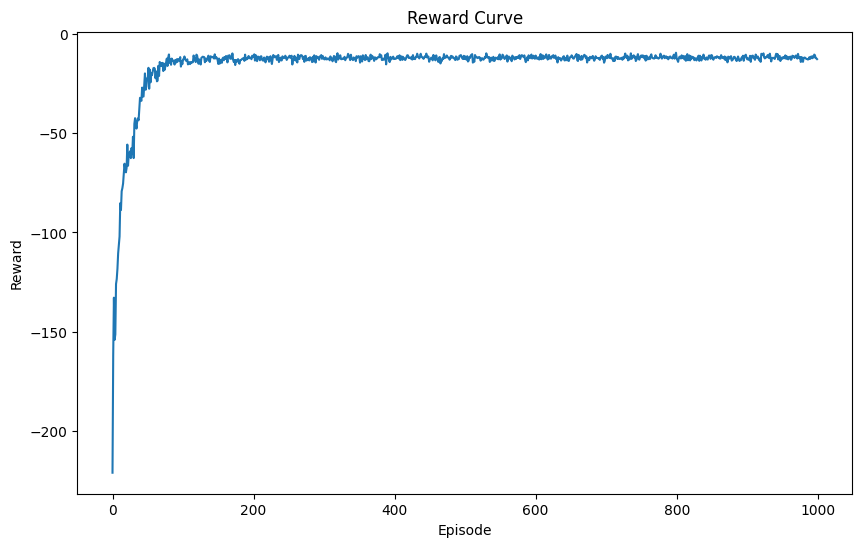

In [110]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

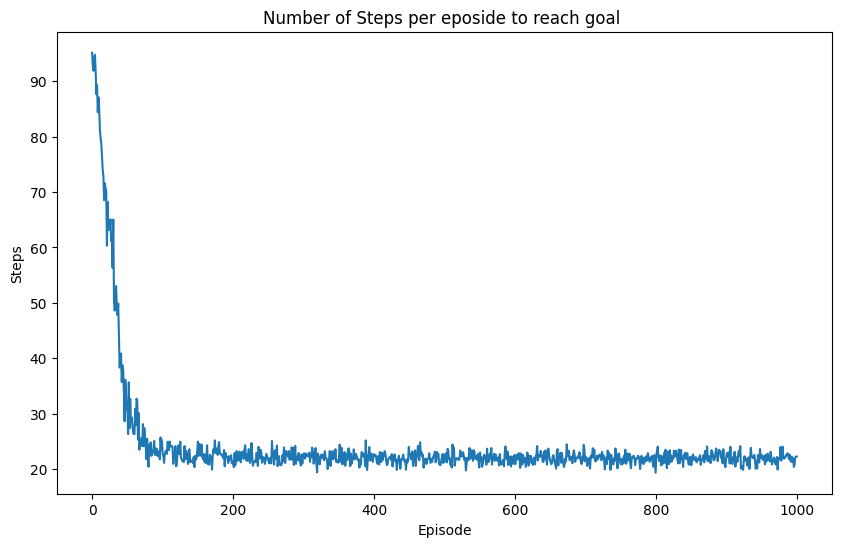

In [111]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

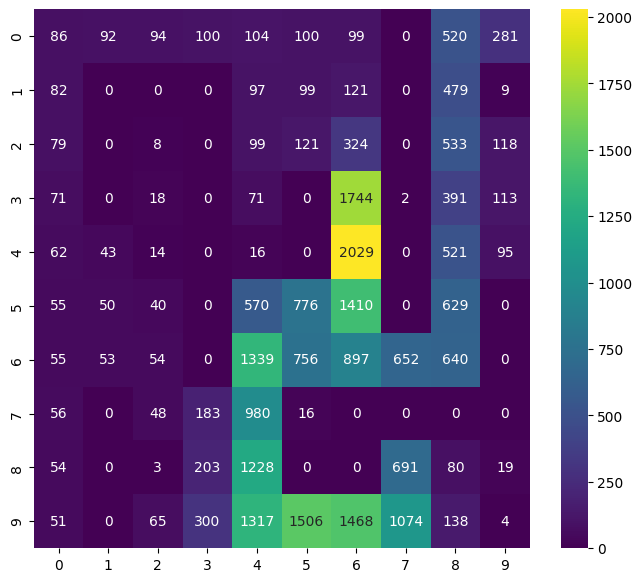

In [112]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

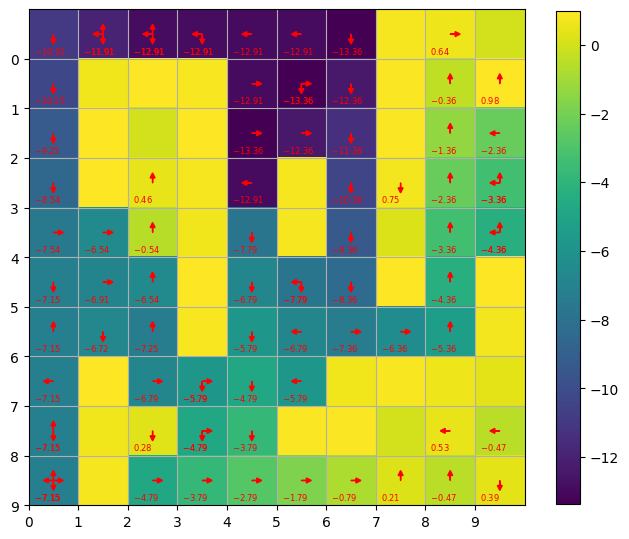

In [113]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.**



*   The best parameter for the configuration comes out to be alpha = 1,gamma = 1 and temp = 1 .The agent tries to explore in softmax fashion.
*   The agnet tries to find the optimal path and  there is no stochasticity as p = 1. Q functions has converged after 1000 episodes but as agent follows softmax approach and there is quite of exploration in action selection.The reward has incraesed to only -20 approx with steps to reach goal state is also close to 20.

*   The state visit graph shows that the agent is trying to find the mid path to Goal state or the right side path towards the Goal state.



**This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.**



*   The start state is (3,6) and the optimal path is being found out by the agent as the agent follows softmax with temp value = 1 .
*   The p = 1 has kept no uncertainty in the transitions and thats why the agent has converged to a higher reward.







### (1) SARSA

In [56]:
class SARSA():

  def __init__(self,env,alpha,gamma,epsilon=0,temp = 1,greedy=False):
    self.greedy = greedy
    self.env = env
    self.aplha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.action_value_function={}
    self.temp = temp
    self.state_visit_count = np.zeros(env.num_states)

    for state in range(self.env.num_states):
      self.action_value_function[state] = {}
      for action in range(self.env.num_actions):
        self.action_value_function[state][action] = np.random.rand()
    for state in self.env.goal_states_seq:
      for action in range(self.env.num_actions):
        self.action_value_function[state][action] = 0

  def action(self,state):
    if(self.greedy):
      if np.random.rand() >= self.epsilon:
        action = max(self.action_value_function[state],key=self.action_value_function[state].get)
      else:
        action = np.random.choice(list(self.action_value_function[state].keys()))
      return action

    else:
      value_function = np.exp(np.array(list(self.action_value_function[state].values())))/self.temp
      softmax_probability = value_function/np.sum(value_function)
      return np.random.choice(len(softmax_probability), p=softmax_probability)


  def train(self,total_episode):
    episode_count = 0
    self.reward_per_episode = np.zeros(total_episode)
    self.reach_goal = np.ones(total_episode) * 100
    while episode_count < total_episode:
      state = self.env.reset()
      action = self.action(state)
      self.state_visit_count[state]+=1
      episodic_timestep = 0
      total_reward = 0
      while True:
        if episodic_timestep > 100:
          break
        next_state, reward = self.env.step(state,action)
        total_reward += reward
        self.state_visit_count[next_state] += 1
        if next_state in self.env.goal_states_seq:
          self.reach_goal[episode_count] = episodic_timestep
          break
        next_action = self.action(next_state)
        self.action_value_function[state][action] = self.action_value_function[state][action] + self.aplha * (reward[0] + self.gamma * self.action_value_function[next_state][next_action] - self.action_value_function[state][action])
        state,action = next_state,next_action
        episodic_timestep+=1
      self.reward_per_episode[episode_count] = total_reward
      episode_count +=1

#### Configuration Parameters - 9
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Greedy

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = True
env.start_state = np.array([[3,6]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ##
## Iter

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [59]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = True)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

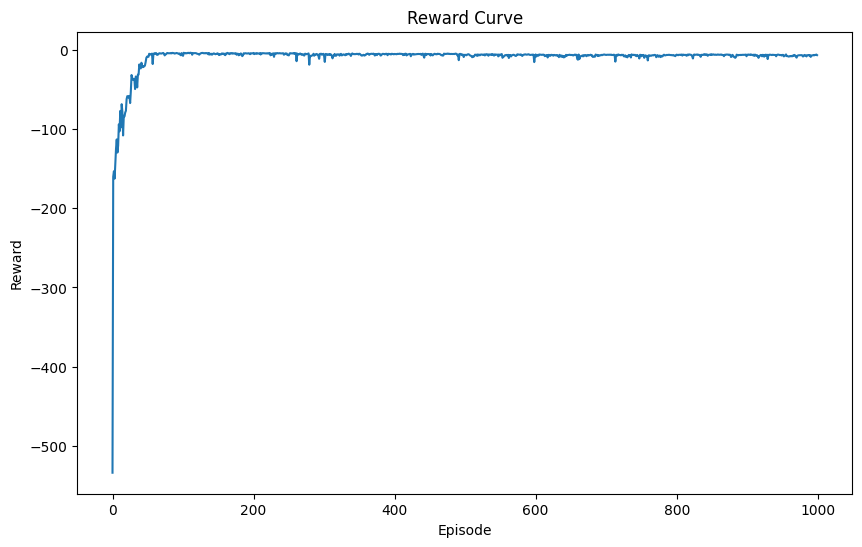

In [60]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

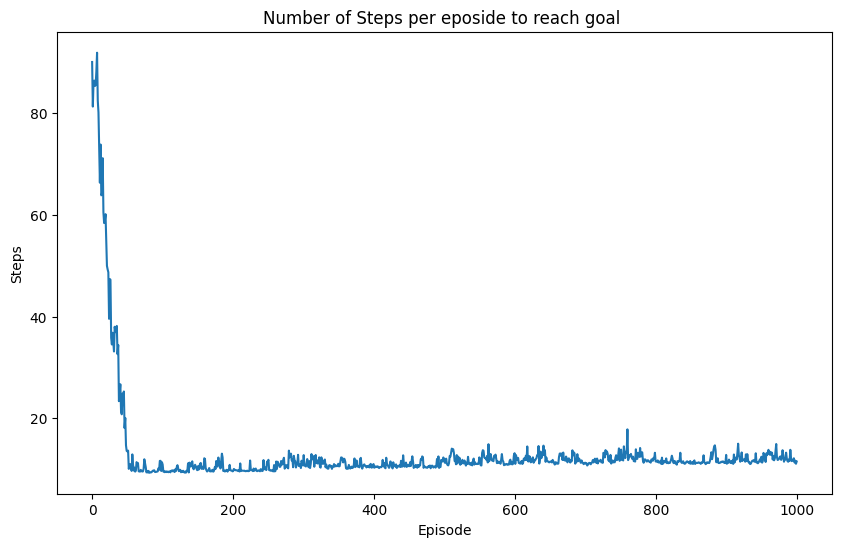

In [61]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

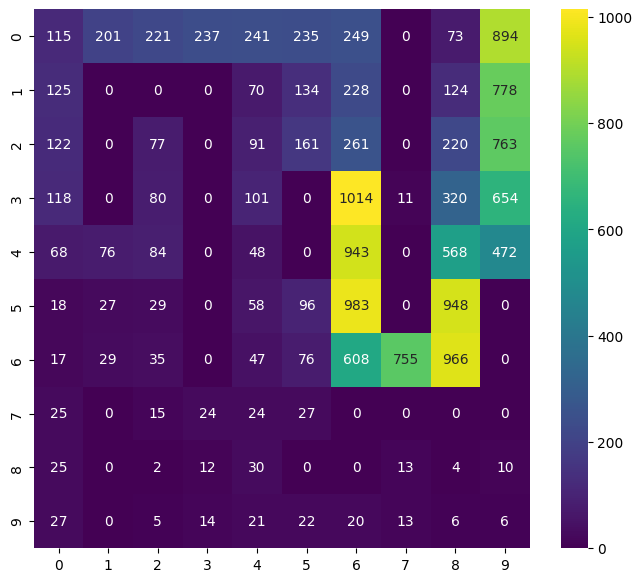

In [62]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

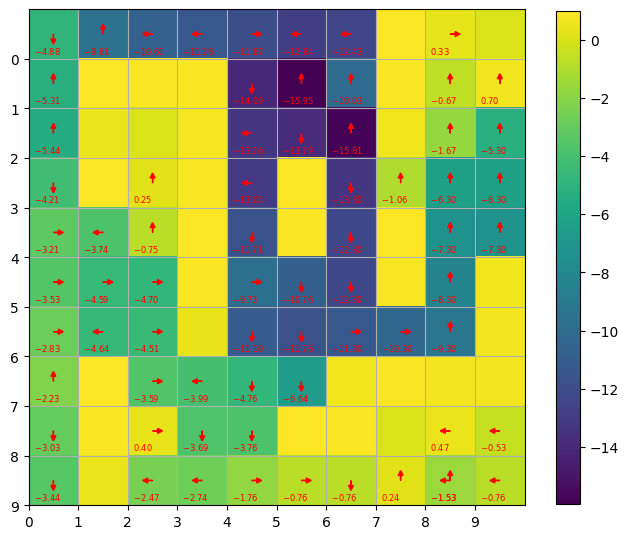

In [64]:
heatMap_optimal_policy(env,agents[5].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = True,Starting state = (3,6) and exploration policy is epsilon greedy. The best hyperparameters found to be alpha = 1,gamma = 1,epsilon = 0.001.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.So in episodic task the max reward can be obtained keeping a high gamma giving high importance to the far away states too. The epsilon value 0.001 shows that the agent is performing better with very less exploration.It is choosing actions mostly greedily with slight exploration so that other states doesn't remain unvisited.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph also shows steeper slope(rise) as p = 1.The stochasticity is only because of wind = True.


*   The no.of steps to reach goal state graph also starts with initially 90 steps per episode on avg but by the 1000th episode almost learns and reaches the goal state on 12-13 steps and keeps on fluctuating because of wind.
*   The heatmap for the frequency of each state visit shows very small number for other states other than the path states as the agent does initially small exploration and once it learns it visits the states close to the path state more frequently.

*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.
*   The wind = True parameter does effect the transition of the agent from one state to the other even though the p value is 1.









#### Configuration Parameters - 10
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Greedy

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = False
env.start_state = np.array([[3,6]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ##
## Iter

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count


1. Plot reward curves (during the training phase with the best hyperparameters).

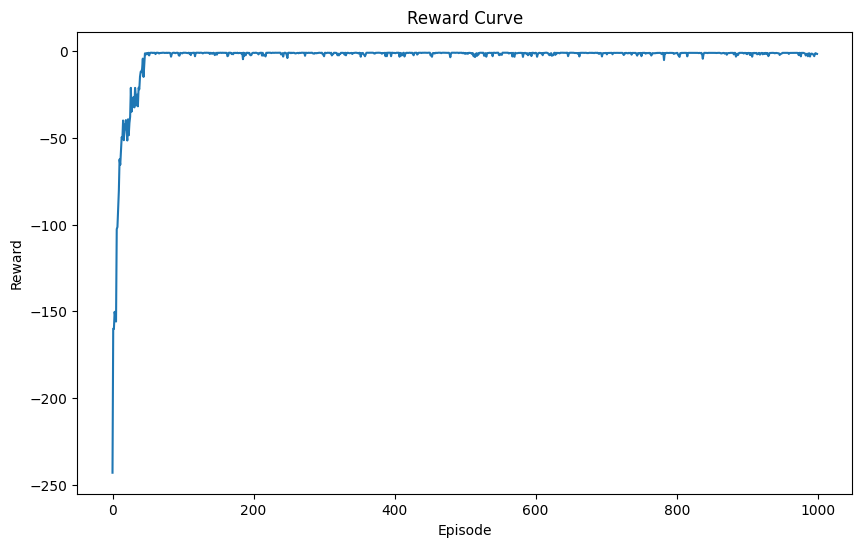

In [ ]:
reward_curve(rewards)

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

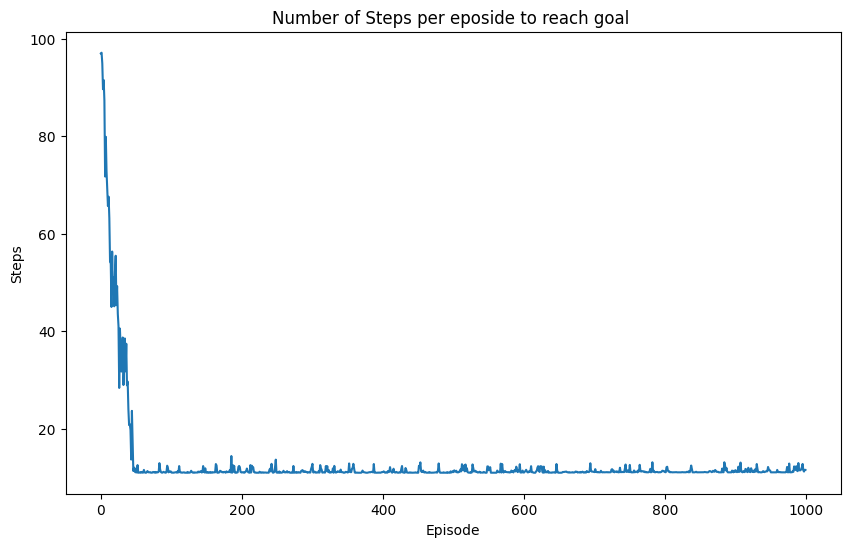

In [ ]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

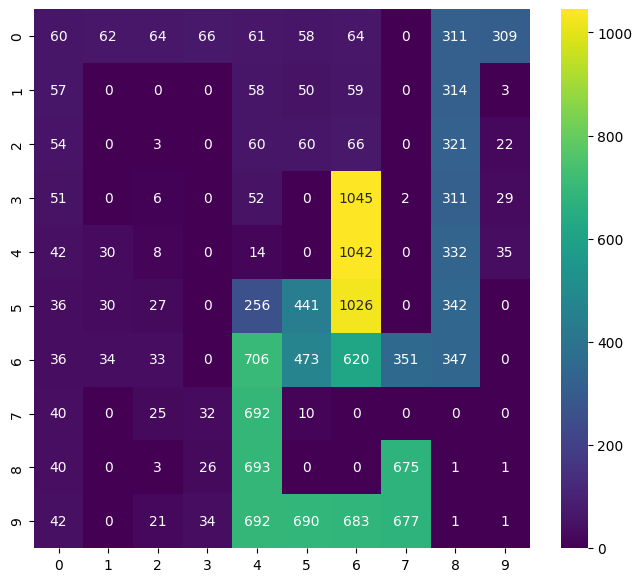

In [ ]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

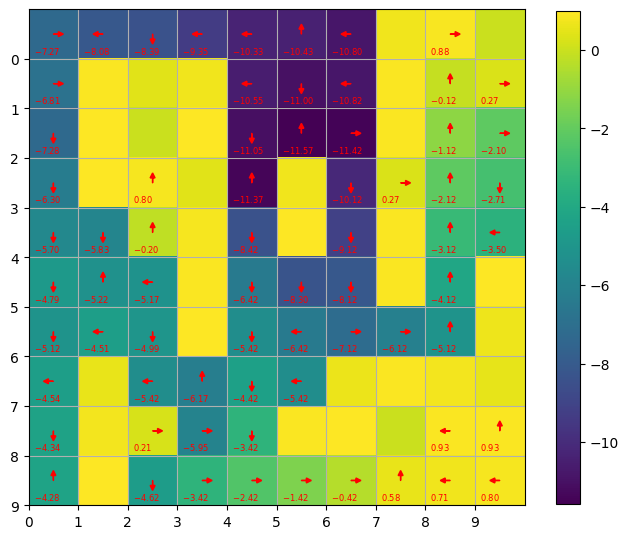

In [ ]:
heatMap_optimal_policy(env,agents[3].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = False,Starting state = (3,6) and exploration policy is epsilon greedy. The best hyperparameters found to be alpha = 1,gamma = 1,epsilon = 0.001.So wind didn't play a big role in hyperparameter.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.So in episodic task the max reward can be obtained keeping a high gamma giving high importance to the far away states too. The epsilon value 0.001 shows that the agent is performing better with very less exploration.It is choosing actions mostly greedily with slight exploration so that other states doesn't remain unvisited.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph doesn't have the rounded edge around the approx 50th - 100th episode as was seen when wind was True.The stochasticity reduces further as there is no more wind and reaches to the optimal reward value slightly quicker and lower.


*   The no.of steps to reach goal state graph also starts with initially approx 100 steps per episode on avg but by the 1000th episode almost learns and reaches the goal state on 12-13 steps.There is less jaggerdness or deviation comparing to wind = True.Also the slope is steeper showing it converges faster.
*   The heatmap for the frequency of each state visit shows significantly less compared to when wind = True for states away from the optimal path.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.
*   The wind = False parameter did effect the transition of the agent from one state to the other even though the p value is 1.There was more deterministic transitions and it converged faster as we can see from no.of steps graph to reach Goal state.









#### Configuration Parameters - 11
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Greedy

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = True
env.start_state = np.array([[0,4]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ##
## Iter

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = True)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

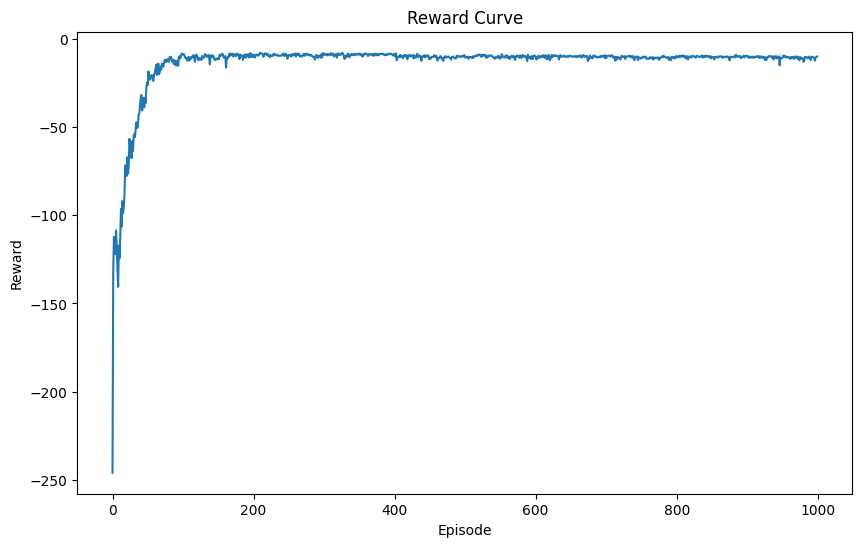

In [ ]:
reward_curve(rewards)

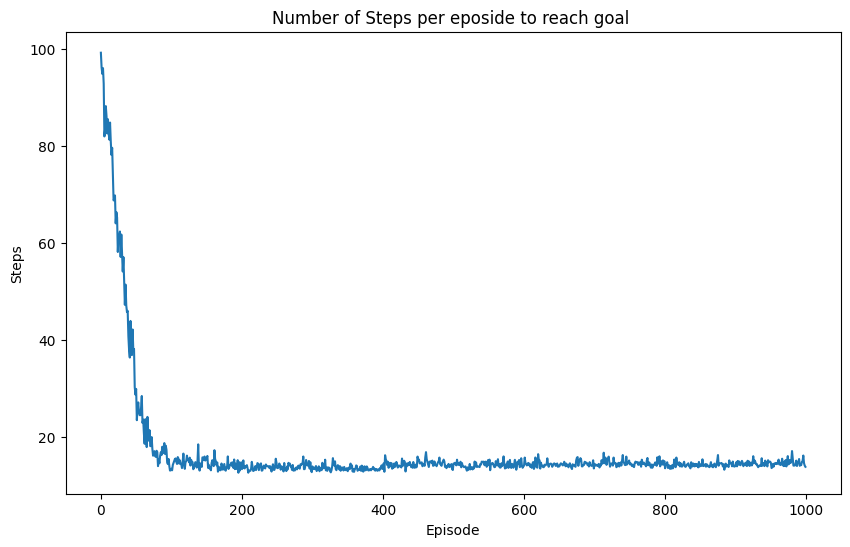

In [ ]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

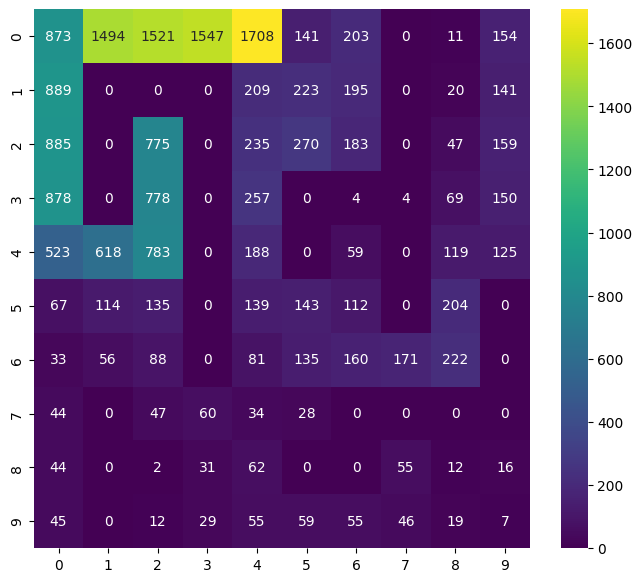

In [ ]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

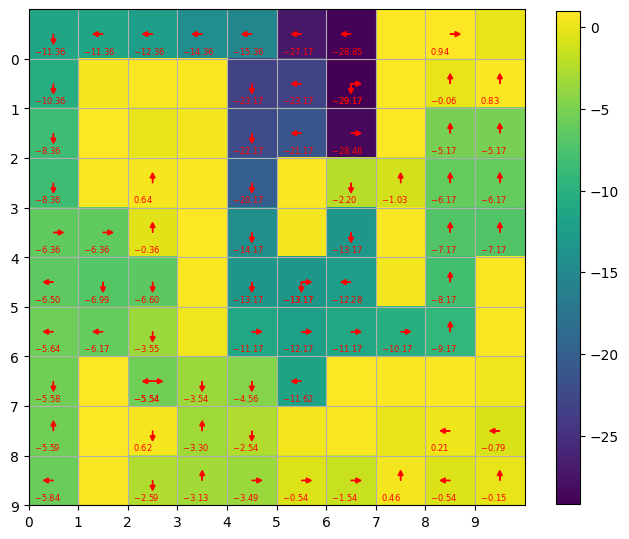

In [ ]:
heatMap_optimal_policy(env,agents[6].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = True, Starting state = (0,4) and exploration policy is epsilon greedy. The best hyperparameters found to be alpha = 1,gamma = 1,epsilon = 0.001.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.So in episodic task the max reward can be obtained keeping a high gamma giving high importance to the far away states too. The epsilon value 0.001 shows that the agent is performing better with very less exploration.It is choosing actions mostly greedily with slight exploration so that other states doesn't remain unvisited.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph also shows steeper slope(rise) as p = 1.The stochasticity is only because of wind = True.But due to wind = True it reaches to a lower reward level in comparison to when wind = False.


*   The no.of steps to reach goal state graph also starts with initially 100 steps per episode on avg but by the 1000th episode almost learns and reaches the goal state on 12-13 steps and keeps on fluctuating because of wind.The graph has rounded corners as it takes slightly more episodes to come closer to optimal value and also there is lot of fluctuations because of wind = True.
*   The heatmap for the frequency of each state visit shows very small number for other states other than the path states as the agent does initially small exploration of 0.001 and once it learns it visits the states close to the path state more frequently.

*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.
*   The wind = True parameter does effect the transition of the agent from one state to the other even though the p value is 1.









#### Configuration Parameters - 12
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Greedy

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = False
env.start_state = np.array([[0,4]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for epsilon in [0.001, 0.01, 0.05, 0.1] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,epsilon)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,epsilon = epsilon,greedy = True)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,epsilon)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.001) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.05) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.001) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.05) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.001) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.05) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.001) ##
## Iter

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.001


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.001,greedy = True)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

1. Plot reward curves (during the training phase with the best hyperparameters).

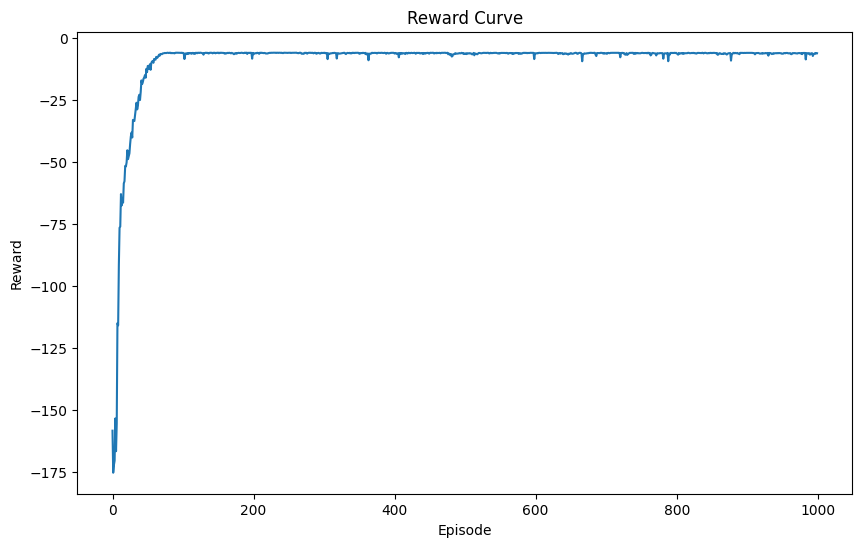

In [ ]:
reward_curve(rewards)

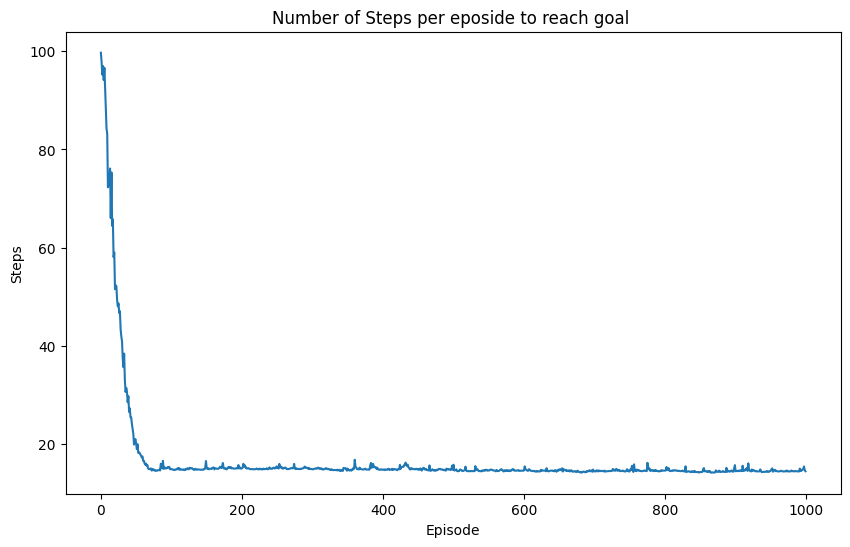

In [ ]:
steps_to_goal(goal_reach)

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

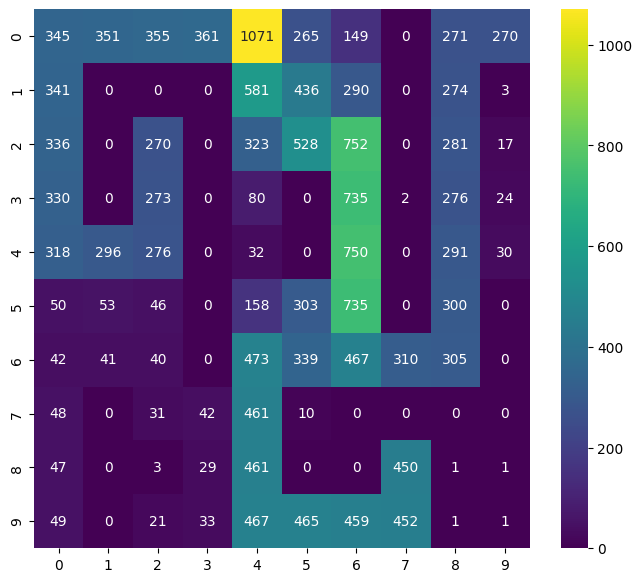

In [ ]:
heatMap_states_visit(state_visit_counts)

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

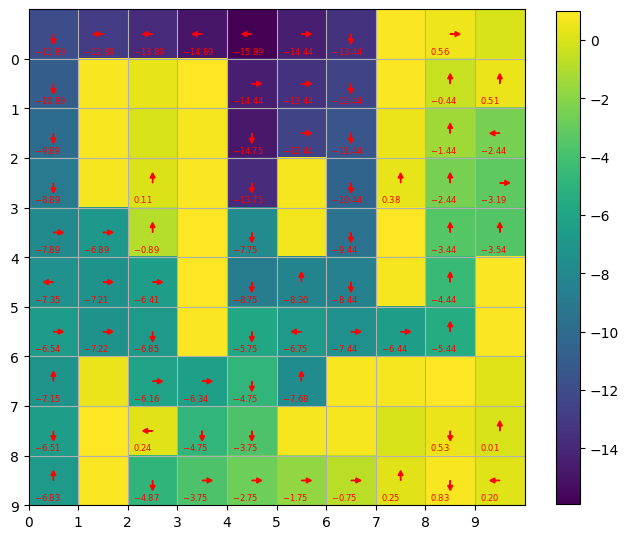

In [ ]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = False,Starting state = (0,4) and exploration policy is epsilon greedy. The best hyperparameters found to be alpha = 1,gamma = 1,epsilon = 0.001.So wind didn't play a big role in hyperparameter.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.So in episodic task the max reward can be obtained keeping a high gamma giving high importance to the far away states too. The epsilon value 0.001 shows that the agent is performing better with very less exploration.It is choosing actions mostly greedily with slight exploration so that other states doesn't remain unvisited.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph does have the rounded edge around the approx 50th - 100th episode as was seen when wind was True.But the stochasticity has reduced so the graph is smoother as wind = False.


*   The no.of steps to reach goal state graph also starts with initially approx 100 steps per episode on avg but by the 1000th episode almost learns and reaches the goal state on 12-13 steps.There is less jaggerdness or deviation comparing to wind = True.
*   The heatmap for the frequency of each state visit shows that the agent has visited more uniformly all states in comparison to when wind = True.Wind helped in the earlier case to visit optimal path states more frequently.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.
*   The wind = False parameter did effect the transition of the agent from one state to the other even though the p value is 1.There was more deterministic transitions.So all the graphs are much smoother.








#### Configuration Parameters - 13
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = True
env.start_state = np.array([[3,6]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ##
## Iteration Count: 14 ::: Hy

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("temp = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
temp =  0.01


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = True)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.01,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

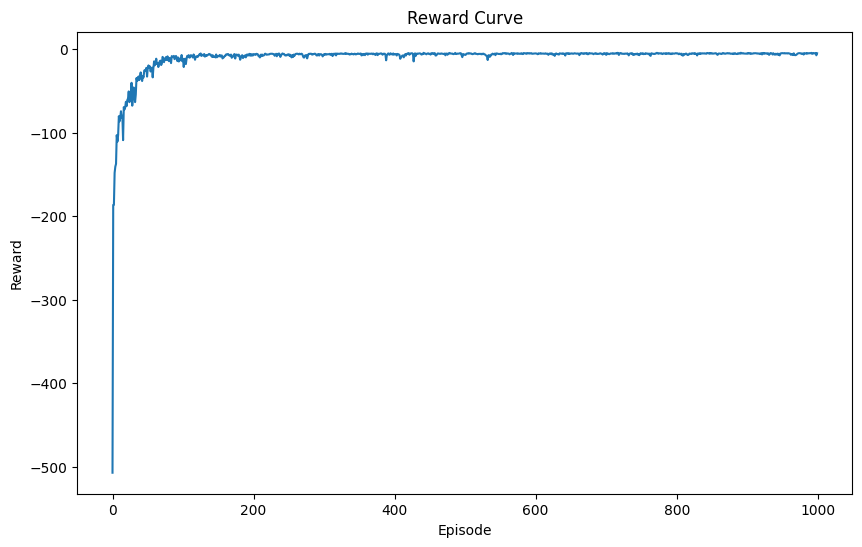

In [ ]:
reward_curve(rewards)

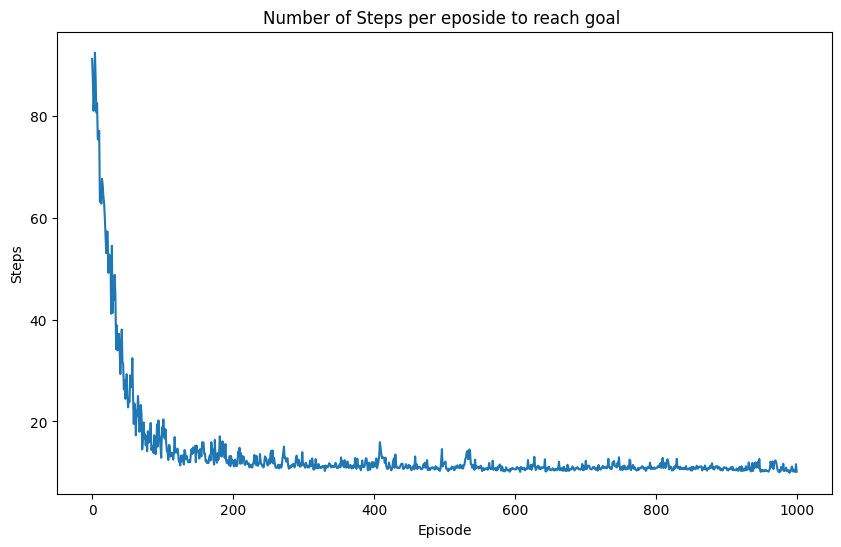

In [ ]:
steps_to_goal(goal_reach)

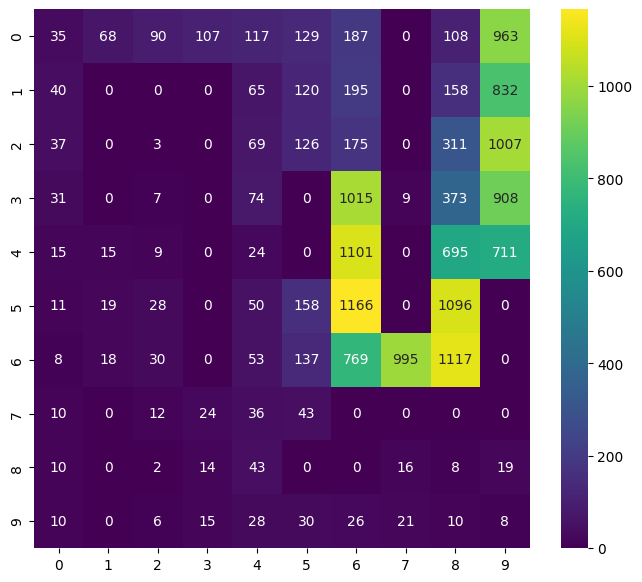

In [ ]:
heatMap_states_visit(state_visit_counts)

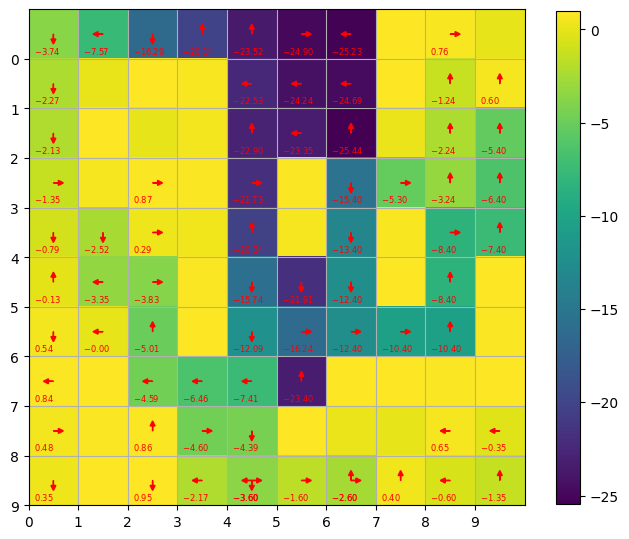

In [ ]:
heatMap_optimal_policy(env,agents[7].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = True,Starting state = (3,6) and exploration policy is softmax. The best hyperparameters found to be alpha = 1,gamma = 1,temp = 0.01.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.The temp value 0.01 shows that the agent is performing slightly more exploration than epsilon greedy.That is the reason the agent takes slightly more episodes to converge then epsilon greedy.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph does have more rounded edge around the approx 50th - 100th episode compared to epsilon greedy.

*   The no.of steps to reach goal state graph also starts with initially approx 90 steps per episode on avg but by the 1000th episode almost learns and takes slightly more steps to reach Goal state compared to epsilon greedy.There is too much jaggerdness or deviation in the graph.
*   The heatmap for the frequency of each state visit shows that the agent has visited optimal path states more frequently.Wind helped in this case to visit optimal path states more frequently.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.







#### Configuration Parameters - 14
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = False
env.start_state = np.array([[3,6]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ##
## Iteration Count: 14 ::: Hy

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  0.01


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[3,6]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.01,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

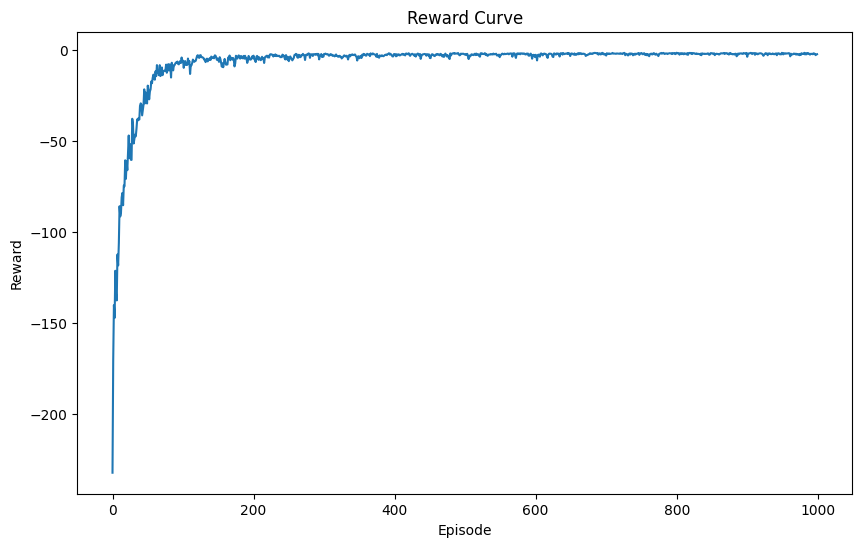

In [ ]:
reward_curve(rewards)

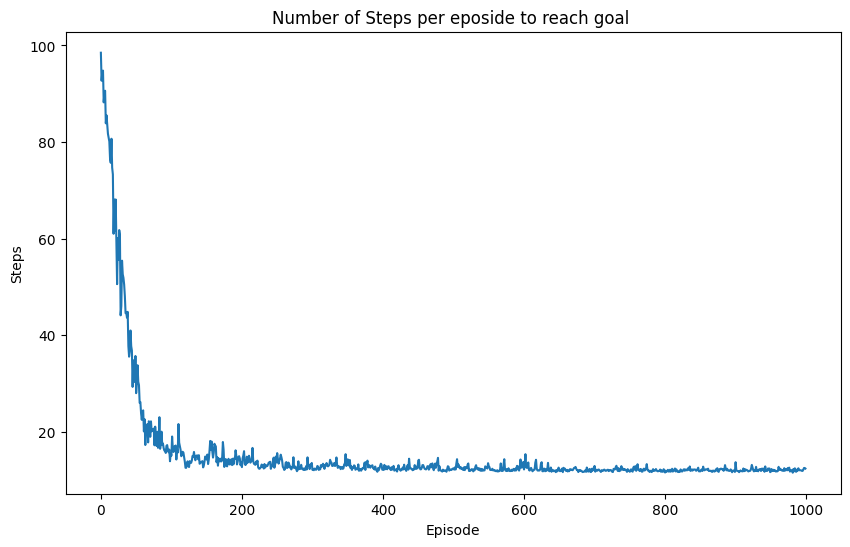

In [ ]:
steps_to_goal(goal_reach)

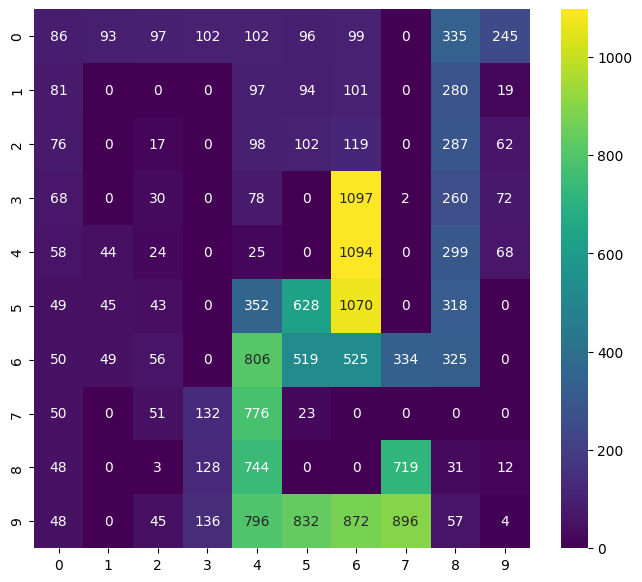

In [ ]:
heatMap_states_visit(state_visit_counts)

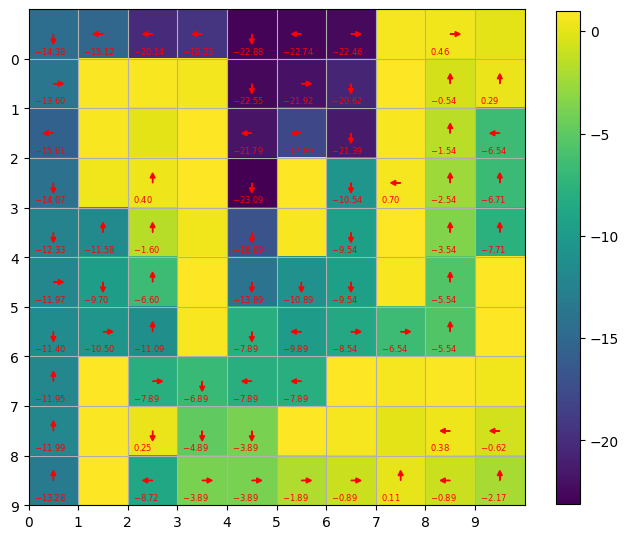

In [ ]:
heatMap_optimal_policy(env,agents[5].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = False,Starting state = (3,6) and exploration policy is softmax. The best hyperparameters found to be alpha = 1,gamma = 1,temp = 0.01.Gamma comes out to be 1 as the episodes need not be continuing task they will end once the agent reaches Goal state.The temp value 0.01 shows that the agent is performing slightly more exploration than epsilon greedy.That is the reason the agent takes slightly more episodes to converge then epsilon greedy.
*   The reward curve shows that the agent keeps on learning step by step and by the 1000th episode it accumulates maximum reward.The graph does have more less rounded edge around the approx 50th - 100th episode compared to when wind = False.

*   The no.of steps to reach goal state graph also starts with initially approx 100 steps per episode on avg but by the 1000th episode almost learns and takes more steps to reach Goal state compared to epsilon greedy.There is too much jaggerdness or deviation in the graph because of initial exploration.
*   The heatmap for the frequency of each state visit shows that the agent has visited optimal path states more frequently.Wind helped in this case to visit optimal path states more frequently.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.







#### Configuration Parameters - 15



Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = True
env.start_state = np.array([[0,4]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ##
## Iteration Count: 14 ::: Hy

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",1.0,best_parameter[0])
print("gamma = ",1.0,best_parameter[1])
print("epsilon = 0.01",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon = 0.01


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = True)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 0.01,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

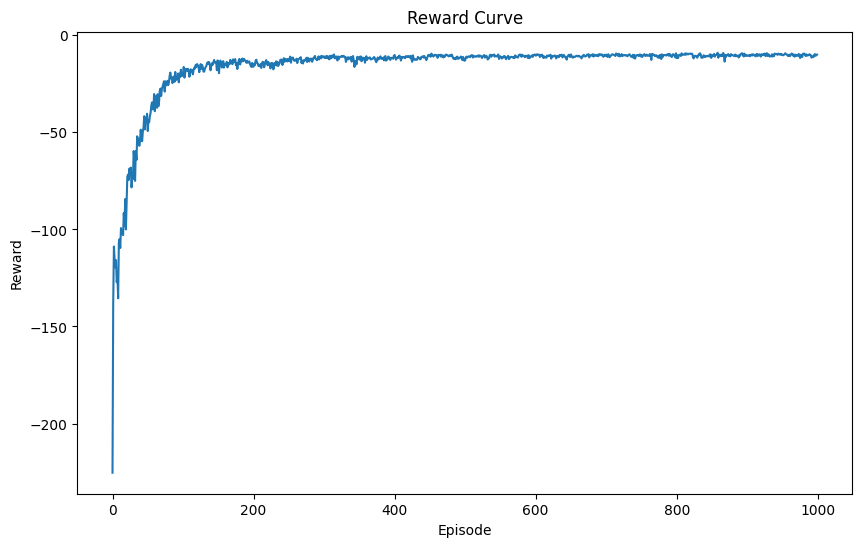

In [ ]:
reward_curve(rewards)

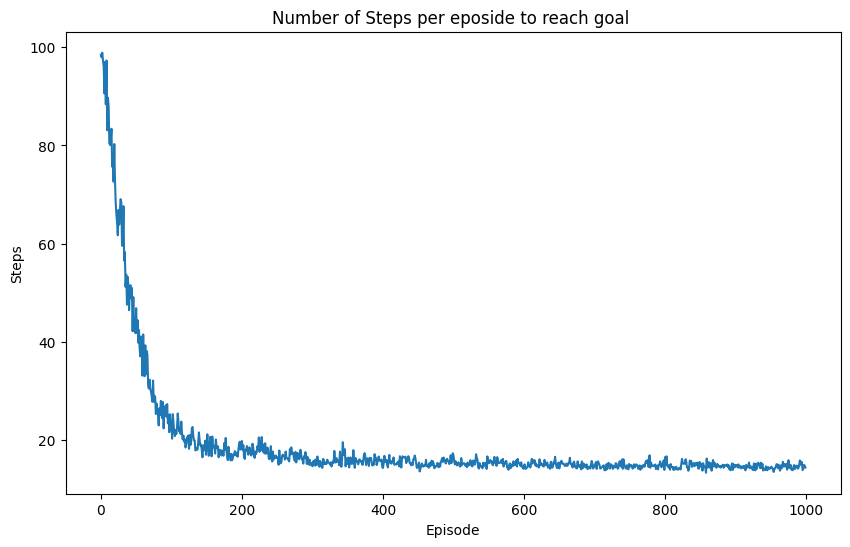

In [ ]:
steps_to_goal(goal_reach)

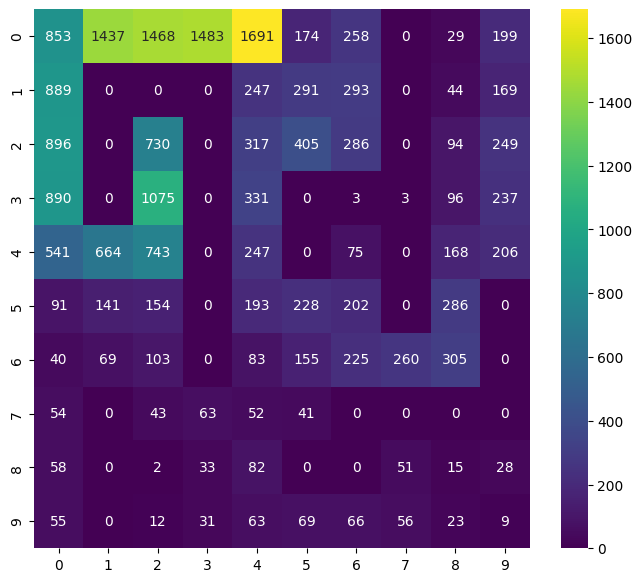

In [ ]:
heatMap_states_visit(state_visit_counts)

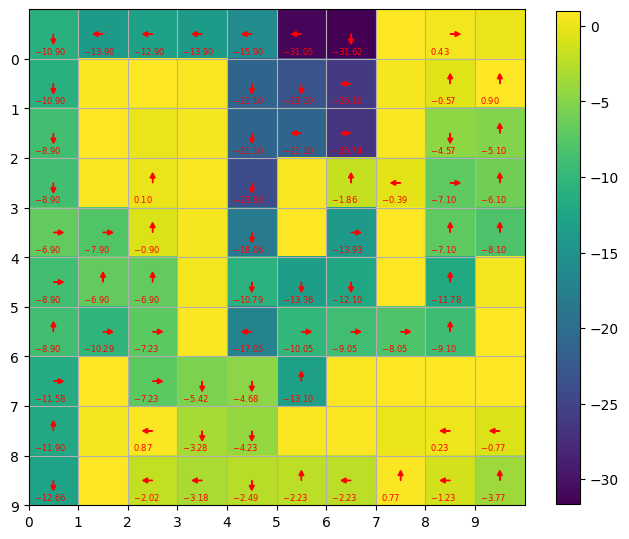

In [ ]:
heatMap_optimal_policy(env,agents[5].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = True,Starting state = (0,4) and exploration policy is softmax. The best hyperparameters found to be alpha = 1,gamma = 1,temp = 0.01.The temp value 0.01 shows that the agent is performing slightly more exploration than epsilon greedy.That is the reason the agent takes slightly more episodes to converge then epsilon greedy.
*   The reward curve shows that the agent keeps on learning step by step and by the 200th episode it starts converging towards max reward.The graph has lot of jaggerdness beacuse of wind = True.

*   The no.of steps to reach goal state graph also starts with initially approx 100 steps per episode on avg also by the 1000th episode the agent still doesn't take minimum steps to reach goal.There is too much jaggerdness or deviation in the graph because of initial exploration.After 1000th episode also the agent hasn't learned completely.
*   The heatmap for the frequency of each state visit shows that the agent has visited all states enough times.Wind does effect in it.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.







#### Configuration Parameters - 16
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

In [ ]:
gw.add_transition_probability(p_good_transition=1,bias=0.5)
env = gw.create_gridworld()
env.wind = False
env.start_state = np.array([[0,4]])
reward_results = {}
iter=0
for alpha in [0.001, 0.01, 0.1, 1.0]:
  for gamma in [0.7, 0.8, 0.9, 1.0]:
    for temp in [0.01, 0.1, 1, 2] :
      iter+=1
      print("#"*2,f"Iteration Count: {iter} ::: Hyperparameter Tunning for  {(alpha,gamma,temp)}","#"*2)
      agents = np.empty(50,dtype=object)
      for i in range(len(agents)):
        agents[i] = SARSA(env,alpha = alpha,gamma = gamma,temp = temp,greedy = False)

      for i in range(len(agents)):
        agents[i].train(1000)
      rewards = np.empty(50,dtype=object)
      goal_reach = np.empty(50 , dtype = object)
      state_visit_counts = np.empty(50,dtype=object)
      for i in range(len(agents)):
        rewards[i] = agents[i].reward_per_episode
        goal_reach[i] = agents[i].reach_goal
        state_visit_counts[i] = agents[i].state_visit_count
      reward_results[(alpha,gamma,temp)] = rewards

## Iteration Count: 1 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.01) ##
## Iteration Count: 2 ::: Hyperparameter Tunning for  (0.001, 0.7, 0.1) ##
## Iteration Count: 3 ::: Hyperparameter Tunning for  (0.001, 0.7, 1) ##
## Iteration Count: 4 ::: Hyperparameter Tunning for  (0.001, 0.7, 2) ##
## Iteration Count: 5 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.01) ##
## Iteration Count: 6 ::: Hyperparameter Tunning for  (0.001, 0.8, 0.1) ##
## Iteration Count: 7 ::: Hyperparameter Tunning for  (0.001, 0.8, 1) ##
## Iteration Count: 8 ::: Hyperparameter Tunning for  (0.001, 0.8, 2) ##
## Iteration Count: 9 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.01) ##
## Iteration Count: 10 ::: Hyperparameter Tunning for  (0.001, 0.9, 0.1) ##
## Iteration Count: 11 ::: Hyperparameter Tunning for  (0.001, 0.9, 1) ##
## Iteration Count: 12 ::: Hyperparameter Tunning for  (0.001, 0.9, 2) ##
## Iteration Count: 13 ::: Hyperparameter Tunning for  (0.001, 1.0, 0.01) ##
## Iteration Count: 14 ::: Hy

In [ ]:
best_parameter,max_mean_reward = None,-np.inf
for hyper,rewards in reward_results.items():
  mean_reward = np.mean(np.mean(rewards,axis = 0))
  if mean_reward>max_mean_reward:
    best_parameter = hyper
    max_mean_reward = mean_reward

print("Best Hyperparameters:")
print("alpha = ",best_parameter[0])
print("gamma = ",best_parameter[1])
print("epsilon = ",best_parameter[2])

Best Hyperparameters:
alpha =  1.0
gamma =  1.0
epsilon =  1


Train the agent

In [ ]:
env = custom_env_instantiation(np.array([[0,4]]),1,wind = False)

agents = np.empty(50,dtype=object)
for i in range(len(agents)):
  agents[i] = SARSA(env,alpha = 1.0,gamma = 1.0,epsilon = 1,greedy = False)

for i in range(len(agents)):
  agents[i].train(1000)
rewards = np.empty(50,dtype=object)
goal_reach = np.empty(50 , dtype = object)
state_visit_counts = np.empty(50,dtype=object)
for i in range(len(agents)):
  rewards[i] = agents[i].reward_per_episode
  goal_reach[i] = agents[i].reach_goal
  state_visit_counts[i] = agents[i].state_visit_count

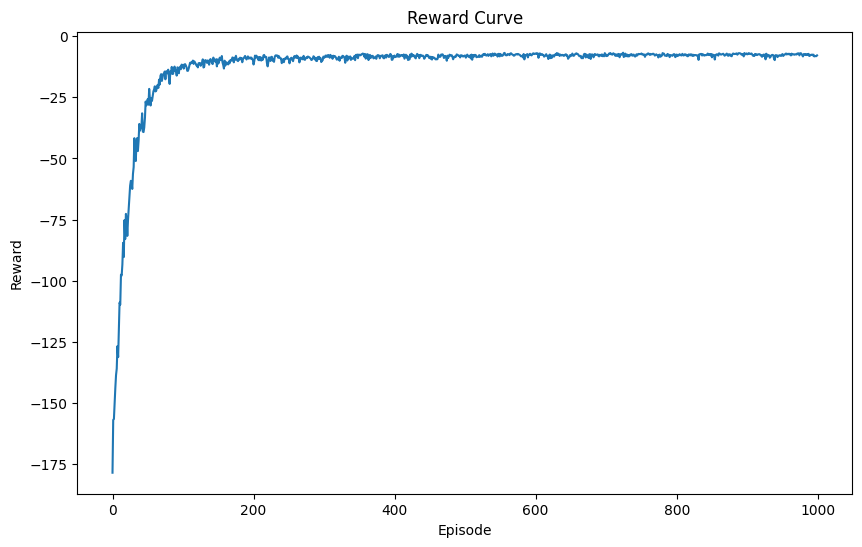

In [ ]:
reward_curve(rewards)

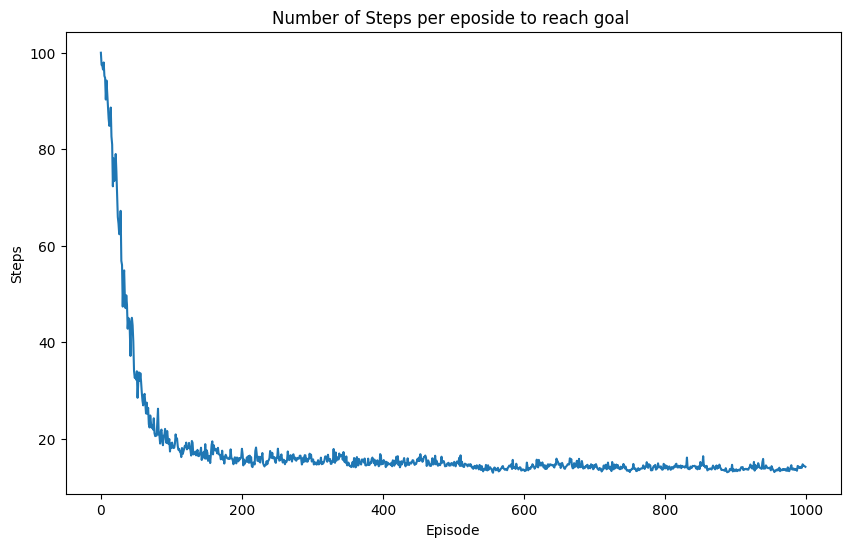

In [ ]:
steps_to_goal(goal_reach)

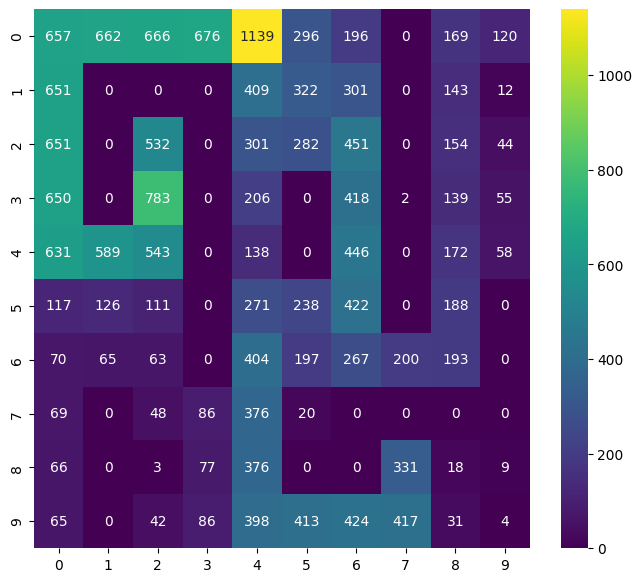

In [ ]:
heatMap_states_visit(state_visit_counts)

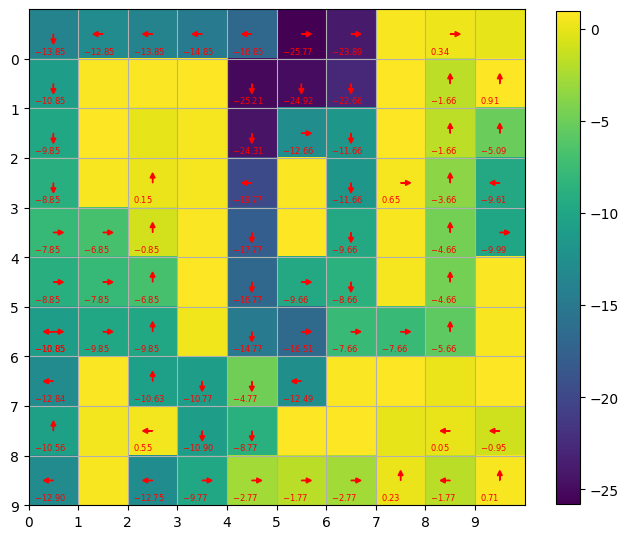

In [ ]:
heatMap_optimal_policy(env,agents[5].action_value_function)

**Analysis**


*   The configuration used for the environment is Wind = False,Starting state = (0,4) and exploration policy is softmax. The best hyperparameters found to be alpha = 1,gamma = 1,temp = 1.The temp value 1 shows that the agent is performing almost unifrom exploration than epsilon greedy.That is the reason the agent takes slightly more episodes to converge then epsilon greedy.
*   The reward curve shows that the agent keeps on learning step by step and by the 200th episode it starts converging towards max reward.The graph has less jaggerdness beacuse of wind = False.

*   The no.of steps to reach goal state graph also starts with initially approx 100 steps per episode on avg also by the 1000th episode the agent still doesn't take minimum steps to reach goal.There is too much jaggerdness or deviation in the graph because of initial exploration.After 1000th episode also the agent hasn't learned completely.
*   The heatmap for the frequency of each state visit shows that the agent has visited all states enough times beacuse of uniform exploration.
*   The optimal policy heat map shows that the Q-value keeps on increasing along the path from start state to the states that are closer to the Goal state.







## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

For case of SARSA the agent tries to learn the path in almost all configurations and tries to find the Goal state avoiding the bad states as the penalty gets added up.So in cases where the start state is (0,4) the agent tries to find the left path to the Goal state i.e 2,2.And when the start state is (3,6) the agent tries to find the right most path i.e (0,9).The epsilon greedy strategy converges with max visit around the optimal path though softmax also finds the optimal path but with lesser clarity.There is slightly more exploration in the case of softmax and shows two paths possibility which are both optimal.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In case of Sarsa the wind do play a role as the agent keeps on fluctuating at minimum no of steps to reach goal state keeps on varying.There is jaggerdness in the graph.But whne wind is False the graph is much smoother as the transitions are more certain.The wind doesnt push the agent to side states.

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

For Q-Learning the agent doesn't find optimal path in all cases.When p= 1 the agent do find the path but when p = 0.7 due to stochasticity the agent keeps on doing uncertain transitions and doesn't converge by 1000 episodes.A Q-Learning updation doesnt have effect by bad states it is found to take the path close to bad states also without the fear of penalty.Softmax also impacts the convergence as it leads to approx uniform policy and delays convergence and also to a lower reward value.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

Wind didn't play a role in case of Q-Learning as it was False for all the configuration.

In [ ]:
# Optional: any supplementary code

Optional Comments: